# Bitcoin Price Prediction Using Twitter Sentimental Analysis

In [3]:
# Import external libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import time
import datetime
import mplfinance as mpf
import seaborn as sns
from dateutil import parser
import re

# Import utility functions
import util.analysis as a
import util.plot as p
import util.text as t

/Users/qianruzhang/anaconda3/envs/ds/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-12-02 18:04:39.109047: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## I Bitcoin Price Analysis

In [2]:
# Read raw bitcoin dataset
btc_data = pd.read_csv("crytpo_data.csv", index_col = 0)
btc_data.head(3)

,symbol,name,price,dayHigh,dayLow,volume,open,close,timestamp,time
_id,,,,,,,,,,
67477c998ad02b4e72f11b46,BTC,Bitcoin USD,96921.72,96962.00,91804.37,8.124583e+10,91938.32,91938.32,1732738201,2024-11-27 20:10:01.889000
67476e8a722b15343d0157f4,BTC,Bitcoin USD,96078.15,96664.20,91804.37,8.124583e+10,91938.32,91938.32,1732734600,2024-11-27 19:10:02.207000
6747607add19519ca50317d8,BTC,Bitcoin USD,96328.41,96530.48,91804.37,8.124583e+10,91938.32,91938.32,1732731000,2024-11-27 18:10:02.034000


In [3]:
btc_data.describe()

,price,dayHigh,dayLow,volume,open,close,timestamp
count,729.000000,729.000000,729.000000,7.290000e+02,729.000000,729.000000,7.290000e+02
mean,83536.379849,84597.927016,81695.471811,7.108863e+10,82767.179084,82767.179084,1.731428e+09
std,10787.795406,10954.365599,10609.820189,3.269491e+10,10831.622600,10831.622600,7.579677e+05
min,67403.940000,68538.000000,66783.770000,1.819931e+10,67785.195000,67785.195000,1.730132e+09
25%,72306.000000,72714.380000,69705.760000,4.551983e+10,70202.875000,70202.875000,1.730773e+09
50%,87671.530000,89600.000000,85010.000000,6.365704e+10,87305.710000,87305.710000,1.731428e+09
75%,92476.100000,93772.260000,90853.000000,8.930853e+10,91938.320000,91938.320000,1.732083e+09
max,99639.100000,99860.000000,97806.000000,1.698264e+11,99005.305000,99005.305000,1.732738e+09


In [4]:
# Drop rows with missing values
btc_data = btc_data.dropna()

# Convert the 'timestamp' column to datetime and set it as the index
btc_data['timestamp'] = pd.to_datetime(btc_data['timestamp'], unit='s')
btc_data = btc_data.set_index('timestamp').sort_index()  # Sort by timestamp in ascending order

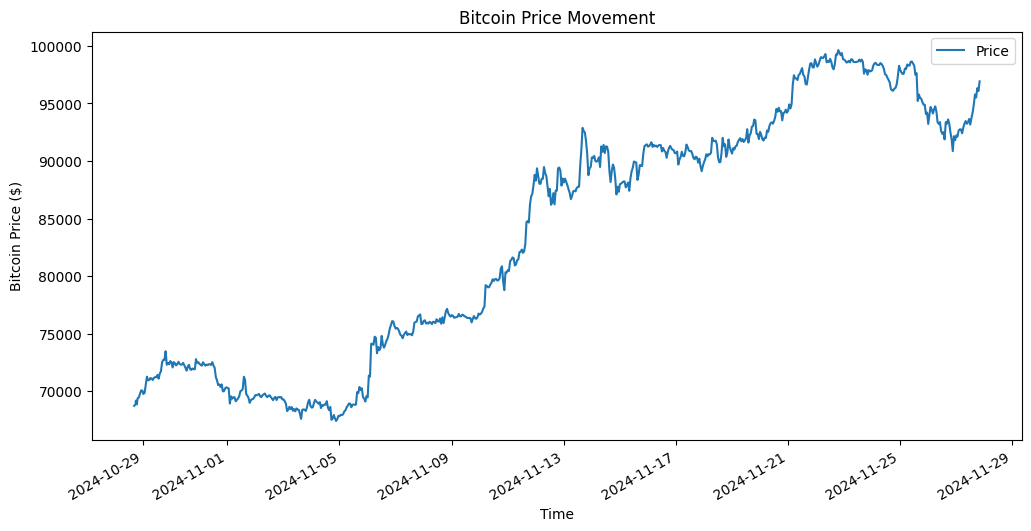

In [5]:
# Plot the Bitcoin price
plt.figure(figsize=(12, 6))
plt.plot(btc_data.index, btc_data["price"], label="Price")
plt.xlabel('Time')
plt.ylabel('Bitcoin Price ($)')
plt.title('Bitcoin Price Movement')
plt.legend()

# Automatically format the x-axis
plt.gcf().autofmt_xdate()
plt.show()

### Bitcoin Price Movement Time Series Analysis
- Calculate SMA-5 and SMA-10 values using **price** column

In [9]:
# Resample to 6-hour intervals
daily_data = btc_data.resample('6h').agg({
    'open': 'first',
    'price': 'last',
    'dayHigh': 'max',
    'dayLow': 'min',
    'volume': 'sum'
})

In [10]:
# Clean and rename columns for mplfinance
daily_data = daily_data.fillna(method='ffill').dropna()
daily_data = daily_data.rename(columns={
    'price': 'Close',
    'dayHigh': 'High',
    'dayLow': 'Low',
    'open': 'Open',
    'volume': 'Volume'
})

daily_data.head(3)

/var/folders/f6/jjmfkpp52bzg1lpytwjwn5jc0000gn/T/ipykernel_9760/2340478572.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  daily_data = daily_data.fillna(method='ffill').dropna()


,Open,Close,High,Low,Volume
timestamp,,,,,
2024-10-28 12:00:00,67939.54,69151.61,69299.0,67532.48,1.169301e+11
2024-10-28 18:00:00,67939.54,70051.00,70288.0,67532.48,1.769670e+11
2024-10-29 00:00:00,67939.54,70965.28,71500.0,67532.48,1.954850e+11


In [11]:
# Add moving averages
daily_data['SMA5'] = daily_data['Close'].rolling(window=5, min_periods=1).mean()
daily_data['SMA10'] = daily_data['Close'].rolling(window=10, min_periods=1).mean()

daily_data.head(3)

,Open,Close,High,Low,Volume,SMA5,SMA10
timestamp,,,,,,,
2024-10-28 12:00:00,67939.54,69151.61,69299.0,67532.48,1.169301e+11,69151.610000,69151.610000
2024-10-28 18:00:00,67939.54,70051.00,70288.0,67532.48,1.769670e+11,69601.305000,69601.305000
2024-10-29 00:00:00,67939.54,70965.28,71500.0,67532.48,1.954850e+11,70055.963333,70055.963333


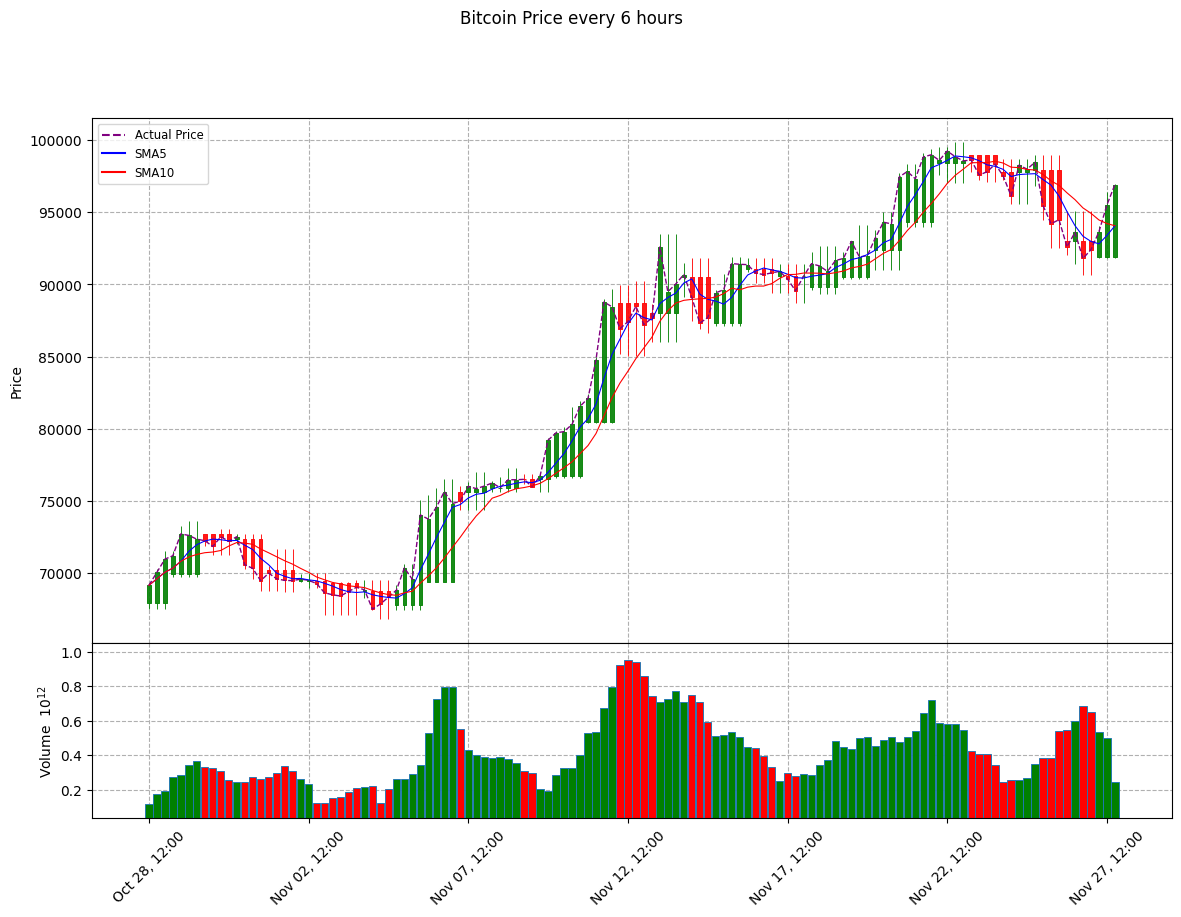

In [12]:
# Create candlestick chart
fig_candle, _ = p.plot_candlestick(daily_data)
plt.show()

### Return outlier Analysis
- Analyze outliers.

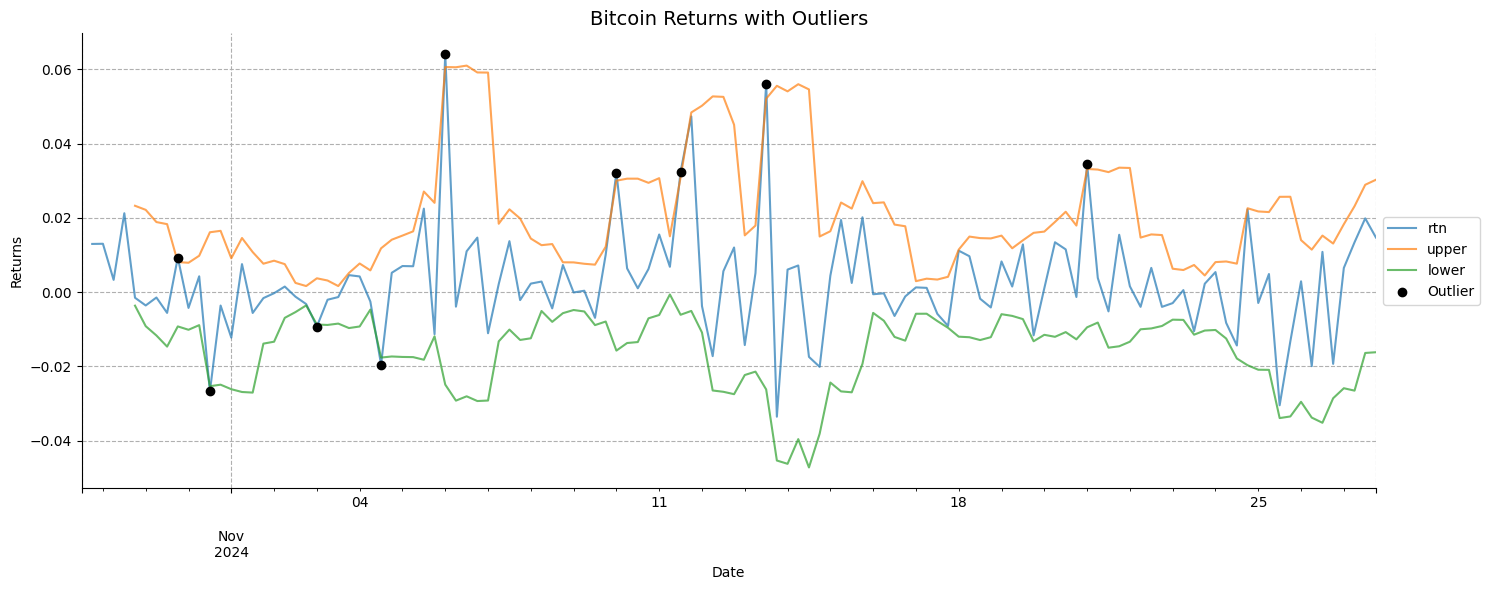

In [16]:
# Analyze returns
returns_analysis = a.analyze_returns(daily_data)
fig_returns, _ = p.plot_returns(returns_analysis)

plt.show()

### Technical Indicator Analysis
- Calculate technical indicators: SMA-5, SMA-10, Bollinger Bands, RSI, MACD, Volatility

/Users/qianruzhang/Documents/GitHub/Crypto-Price-and-Twitter-Sentimental-Analysis/util/analysis.py:51: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['RSI'].fillna(50, inplace=True)  # Fill initial NaN values


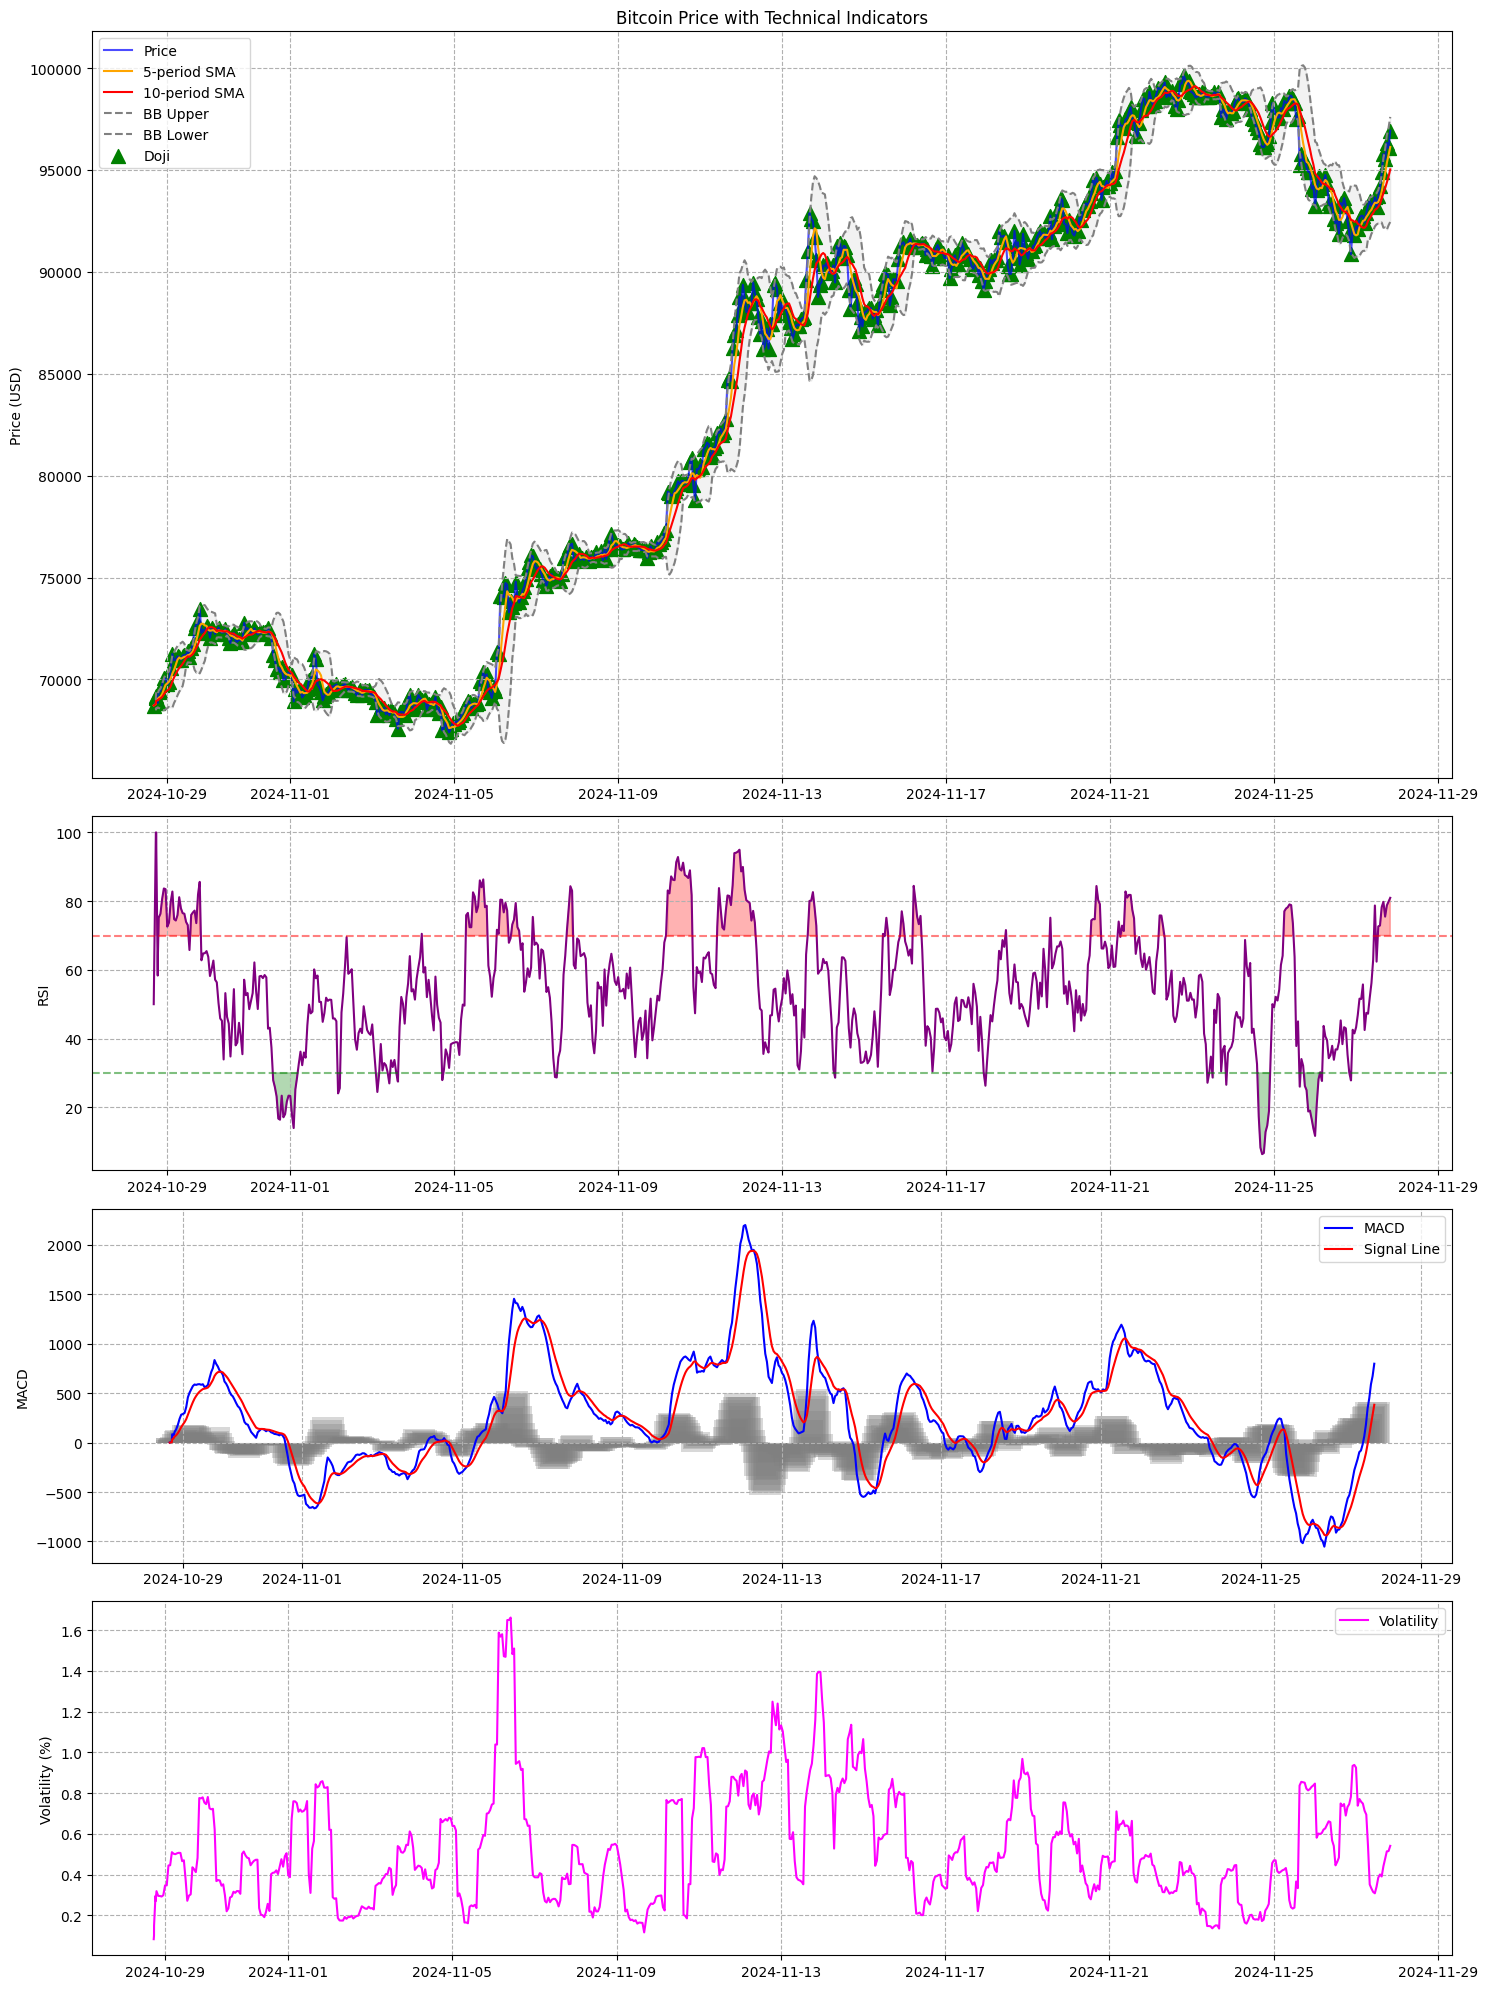

In [17]:
# Example usage
df_with_indicators = a.calculate_technical_indicators(btc_data)

# If you want pattern detection (only if you have OHLC data):
if all(col in btc_data.columns for col in ['open', 'close', 'dayHigh', 'dayLow']):
    df_with_indicators = a.detect_patterns(df_with_indicators)
    fig_technical = p.plot_technical_analysis(df_with_indicators, include_patterns=True)
else:
    fig_technical = p.plot_technical_analysis(df_with_indicators, include_patterns=False)

plt.show()

In [18]:
# Clean hourly BTC price data
hr_btc = df_with_indicators
hr_btc['time'] = pd.to_datetime(hr_btc['time'], format="mixed")
hr_btc['time'] = hr_btc['time'].dt.floor('h')
  
hr_btc.head(3)

,symbol,name,price,dayHigh,dayLow,volume,open,close,time,SMA_5,...,BB_middle,BB_upper,BB_lower,RSI,MACD,Signal_Line,MACD_Histogram,volatility,Doji,Hammer
timestamp,,,,,,,,,,,,,,,,,,,,,
2024-10-28 16:14:23,BTC,Bitcoin USD,68720.00,69299.0,67532.48,2.338602e+10,67939.54,67939.54,2024-10-28 16:00:00,68720.00,...,68720.00,NaN,NaN,50.0,0.000000,0.000000,0.000000,NaN,True,False
2024-10-28 17:29:02,BTC,Bitcoin USD,68862.88,69299.0,67532.48,2.338602e+10,67939.54,67939.54,2024-10-28 17:00:00,68791.44,...,68791.44,68993.502834,68589.377166,100.0,11.397835,2.279567,9.118268,NaN,True,False
2024-10-28 17:33:29,BTC,Bitcoin USD,69086.55,69299.0,67532.48,2.338602e+10,67939.54,67939.54,2024-10-28 17:00:00,68889.81,...,68889.81,69259.315855,68520.304145,100.0,38.040494,9.431752,28.608741,0.082653,True,False


In [19]:
hr_btc.to_csv('hourly_btc_tw_data.csv')

## II Twitter Sentimental Analysis

In [20]:
# Read raw twitter dataset
tw_data = pd.read_csv('twitter_data.csv',index_col=0)
tw_data.head(3)

,symbol,name,tweet_id,screen_name,bookmarks,favorites,created_at,text,lang,quotes,replies,retweets,time
_id,,,,,,,,,,,,,
671fe1125a22311369600909,BTC,bitcoin,1849905253916786767,hamptonism,1144.0,9408.0,Fri Oct 25 20:05:56 +0000 2024,Switzerland unveils a new statue honoring the ...,en,78.0,113.0,803.0,2024-10-28 19:08:02.786000
671fe1125a2231136960090a,BTC,bitcoin,1850228656704049285,Ashcryptoreal,88.0,9210.0,Sat Oct 26 17:31:02 +0000 2024,"If Bitcoin breaks $72,000 by the end \nof Octo...",en,21.0,952.0,1278.0,2024-10-28 19:08:02.786000
671fe1125a2231136960090b,BTC,bitcoin,1849812562323325395,Vivek4real_,23.0,4219.0,Fri Oct 25 13:57:37 +0000 2024,"Like, If you think Microsoft should convert $7...",en,14.0,163.0,339.0,2024-10-28 19:08:02.786000


### Test out Sentimental Analysis Libraries
### 1. Flair Sentiment Analysis
- Test out Flair using selected twitter sample.
- Reference: [Flair](https://github.com/flairNLP/flair)

In [21]:
# Test out Flair using selected Twitter samples
from flair.data import Sentence
from flair.nn import Classifier

sample = tw_data.iloc[0]["text"]
print("Sample: ", sample)
sentence = Sentence(sample)

tagger = Classifier.load('sentiment')
tagger.predict(sentence)

print("Sentiment Value: ", sentence.labels[0].value)
print("Sentiment Confidence: ", sentence.labels[0].score)

/Users/qianruzhang/anaconda3/envs/ds/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-12-02 14:13:47.870854: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Sample:  Switzerland unveils a new statue honoring the creator of Bitcoin, 
Satoshi Nakamoto. https://t.co/viEr8u1KEQ
Sentiment Value:  POSITIVE
Sentiment Confidence:  0.9328526854515076


### 2. VADER Sentiment Analysis
- Test out VADER using selected Twitter sample.
- Reference: [VADER Sentiment Analysis](https://github.com/cjhutto/vaderSentiment)

In [ ]:
# Test out VADER using selected Twitter sample
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

sample = tw_data.iloc[0]["text"]
print("Sample: ", sample)

analyzer = SentimentIntensityAnalyzer()

vs = analyzer.polarity_scores(sample)
print("{:-<65} {}".format(sample, str(vs)))

Sample:  Switzerland unveils a new statue honoring the creator of Bitcoin, 
Satoshi Nakamoto. https://t.co/viEr8u1KEQ
Switzerland unveils a new statue honoring the creator of Bitcoin, 
Satoshi Nakamoto. https://t.co/viEr8u1KEQ {'neg': 0.0, 'neu': 0.784, 'pos': 0.216, 'compound': 0.5106}


### Data Preprocessing
- Extract link values from the **text** column with regex.
- Remove all "\n" from the **text** column.
- Remove any missing value.
- Remove any empty string for the **text** column.
- Remove any Tweets that have minor popularity,  where column quotes or replies or retweets or bookmarks or favorites is less than 10.
- Rmove any Tweets that are non-English.


In [124]:
# Assert if there is any missing values for the **text** column
assert tw_data.isnull().sum()['text'] == 0

AssertionError: 

In [125]:
# If there is missing values, drop these missing values
tw_data = tw_data.dropna()

In [126]:
# Extract link values from the **text** column with regex.
tw_data['text'] = tw_data['text'].apply(
  lambda x: re.sub(r'https?://\S+', '', x).strip()
  )  
# Remove all "\n" from the **text** column.
tw_data['text'] = tw_data['text'].replace('\n', '', regex=True)

tw_data.iloc[1]['text']

'If Bitcoin breaks $72,000 by the end of October, I will give $2,000 BTC to 20 people who like this post.'

In [127]:
# Assert if there is any empty strings for the **text** column
assert len(tw_data.index[tw_data['text'] == ''].tolist()) == 0

AssertionError: 

In [129]:
# Check empty string for the **text** colum
print("Number of empty strings: ", len(tw_data.index[tw_data['text'] == ''].tolist()))
tw_data.index[tw_data['text'] == ''].tolist()[:3]

Number of empty strings:  39


['6725c23c2ecab7f9c39b03c1',
 '6725fa7e69400ce2a905b5de',
 '6726952c7222003579d6c677']

In [ ]:
# Drop every row where **text** column is an empty string
tw_data = tw_data.drop(tw_data[tw_data['text'].isna() | (tw_data['text'].str.strip() == '')].index)

In [133]:
# Assert if there is any empty strings for the **text** column
assert len(tw_data.index[tw_data['text'] == ''].tolist()) == 0

In [ ]:
# Drop rows where column quotes or replies or retweets or bookmarks or favorites is less than 10.
tw_data = tw_data.drop(
  tw_data[
    (tw_data['quotes'] < 10) | 
    (tw_data['replies'] < 10) | 
    (tw_data['retweets'] < 10) | 
    (tw_data['bookmarks'] < 10) | 
    (tw_data['favorites'] < 10)
  ].index
)

In [ ]:
# Drop rows where column lang is not "en" (Twitter text is not in English)
tw_data = tw_data.drop(tw_data[(tw_data['lang'] != 'en')].index)

In [ ]:
# Apply Flair sentiment anaylysis to the twitter dataset.
tw_data[['fl_sentiment', 'fl_confidence']] = tw_data['text'].apply(
  lambda x: pd.Series(t.flair_sentiment(x))
  )

_id
671fe1125a22311369600909    0.837527
Name: fl_confidence, dtype: float64

In [135]:
# Apply VADER sentiment anaylysis to the twitter dataset.
tw_data[['vd_negative', 'vd_neutral', 'vd_positive', 'vd_compound']] = tw_data['text'].apply(
  lambda x: pd.Series(t.vader_sentiment(x))
  )

In [151]:
tw_data.head(3)

,symbol,name,tweet_id,screen_name,bookmarks,favorites,created_at,text,lang,quotes,replies,retweets,time,fl_sentiment,fl_confidence,vd_negative,vd_neutral,vd_positive,vd_compound
0,BTC,bitcoin,1849905253916786767,hamptonism,1144.0,9408.0,Fri Oct 25 20:05:56 +0000 2024,Switzerland unveils a new statue honoring the ...,en,78.0,113.0,803.0,2024-10-28 19:08:02.786,POSITIVE,0.837527,0.0,0.769,0.231,0.5106
1,BTC,bitcoin,1850228656704049285,Ashcryptoreal,88.0,9210.0,Sat Oct 26 17:31:02 +0000 2024,"If Bitcoin breaks $72,000 by the end of Octobe...",en,21.0,952.0,1278.0,2024-10-28 19:08:02.786,NEGATIVE,-0.999922,0.0,0.889,0.111,0.3612
2,BTC,bitcoin,1849812562323325395,Vivek4real_,23.0,4219.0,Fri Oct 25 13:57:37 +0000 2024,"Like, If you think Microsoft should convert $7...",en,14.0,163.0,339.0,2024-10-28 19:08:02.786,NEGATIVE,-0.999045,0.0,0.839,0.161,0.3612


In [153]:
# Convert current cleaned data to csv
tw_data.to_csv('processed_twitter_data.csv', index=False)

## III Visualize Preprocessed Twitter Sentiment Data

In [22]:
# Read processed Twitter dataset
tw_data = pd.read_csv('processed_twitter_data.csv')
tw_data.describe()

,tweet_id,bookmarks,favorites,quotes,replies,retweets,fl_confidence,vd_negative,vd_neutral,vd_positive,vd_compound
count,7.143000e+03,7143.00000,7143.000000,7143.000000,7143.000000,7143.000000,7143.000000,7143.000000,7143.000000,7143.000000,7143.000000
mean,1.854997e+18,511.99482,9616.969761,107.382472,917.223016,1969.787344,-0.668495,0.022130,0.879017,0.098849,0.217721
std,6.128667e+15,1109.09054,14108.021755,281.788023,2406.958957,3493.000950,0.682040,0.072371,0.134625,0.123685,0.391329
min,1.722846e+18,10.00000,193.000000,10.000000,11.000000,34.000000,-0.999997,0.000000,0.256000,0.000000,-0.945100
25%,1.853150e+18,80.00000,2704.000000,19.000000,126.000000,420.000000,-0.999665,0.000000,0.765000,0.000000,0.000000
50%,1.855578e+18,177.00000,5539.000000,38.000000,313.000000,883.000000,-0.997370,0.000000,0.906000,0.000000,0.000000
75%,1.857891e+18,403.00000,11811.500000,83.000000,1034.000000,2036.500000,-0.882649,0.000000,1.000000,0.206000,0.524200
max,1.861854e+18,17293.00000,208292.000000,3902.000000,50094.000000,43987.000000,0.999707,0.647000,1.000000,0.744000,0.976200


### Visualize Flair Sentiment Movements
- Preprocess fl_confidence value using **fl_sentiment** column.

In [68]:
# Preprocess fl_confidence value by fl_sentiment column.
tw_data['fl_confidence'] = np.where(tw_data['fl_sentiment'] == 'NEGATIVE', 
                                 -tw_data['fl_confidence'], 
                                 tw_data['fl_confidence'])
tw_data.head(3)

,symbol,name,tweet_id,screen_name,bookmarks,favorites,created_at,text,lang,quotes,replies,retweets,time,fl_sentiment,fl_confidence,vd_negative,vd_neutral,vd_positive,vd_compound
0,BTC,bitcoin,1849905253916786767,hamptonism,1144.0,9408.0,Fri Oct 25 20:05:56 +0000 2024,Switzerland unveils a new statue honoring the ...,en,78.0,113.0,803.0,2024-10-28 19:08:02.786,POSITIVE,0.837527,0.0,0.769,0.231,0.5106
1,BTC,bitcoin,1850228656704049285,Ashcryptoreal,88.0,9210.0,Sat Oct 26 17:31:02 +0000 2024,"If Bitcoin breaks $72,000 by the end of Octobe...",en,21.0,952.0,1278.0,2024-10-28 19:08:02.786,NEGATIVE,-0.999922,0.0,0.889,0.111,0.3612
2,BTC,bitcoin,1849812562323325395,Vivek4real_,23.0,4219.0,Fri Oct 25 13:57:37 +0000 2024,"Like, If you think Microsoft should convert $7...",en,14.0,163.0,339.0,2024-10-28 19:08:02.786,NEGATIVE,-0.999045,0.0,0.839,0.161,0.3612


### 1. Visualize Mean and Median Values
- Calculate the mean and median of **confidence** column grouped by each hour.
- Calculate the mean and median of **confidence** column grouped by day.

In [69]:
# Convert **time** column datatype
tw_data['time'] = pd.to_datetime(tw_data['time'])

tw_data = tw_data.sort_values(by='time')

In [70]:
# Hourly mean
f_hr_mean = tw_data.groupby(
  tw_data['time'].dt.floor('h')
  )['fl_confidence'].mean().reset_index()

f_hr_mean.head(3)

,time,fl_confidence
0,2024-10-28 19:00:00,-0.382009
1,2024-10-28 20:00:00,-0.571712
2,2024-10-28 21:00:00,-0.437302


In [76]:
# Hourly median
f_hr_med = tw_data.groupby(
  tw_data['time'].dt.floor('h')
  )['fl_confidence'].median().reset_index()

f_hr_med.head(3)

,time,fl_confidence
0,2024-10-28 19:00:00,-0.944707
1,2024-10-28 20:00:00,-0.959424
2,2024-10-28 21:00:00,-0.966333


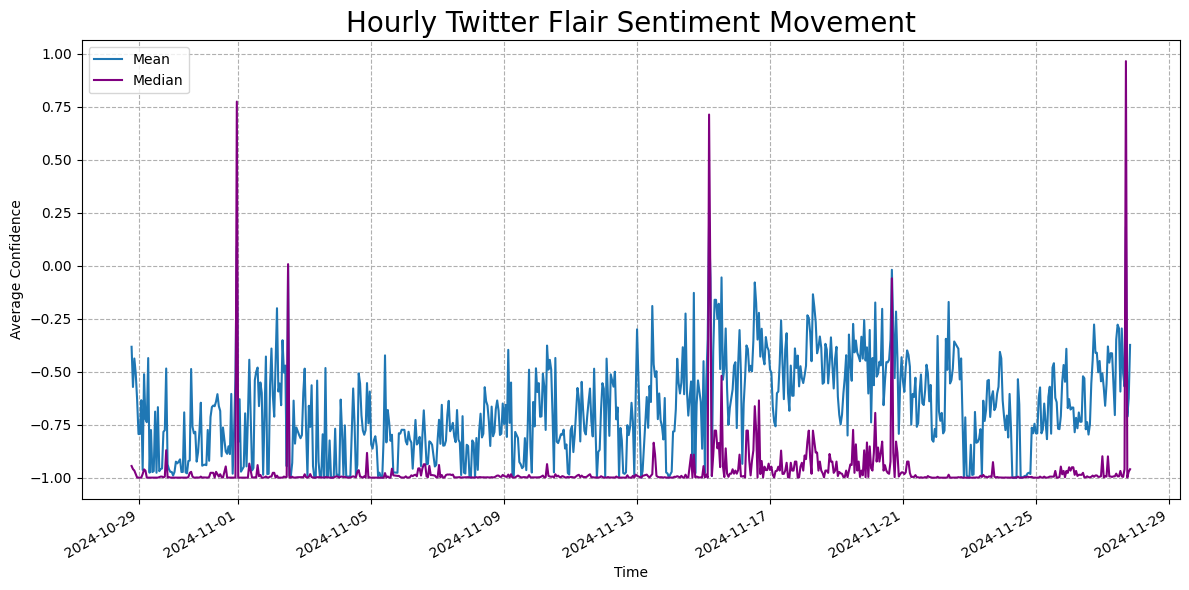

In [77]:
# Plot hourly twitter sentiment movement on **fl_confidence** column
plt.figure(figsize=(12, 6))

plt.plot(f_hr_mean['time'], f_hr_mean['fl_confidence'], label='Mean')
plt.plot(f_hr_med['time'], f_hr_med['fl_confidence'], color='purple', label='Median')

plt.title('Hourly Twitter Flair Sentiment Movement', fontsize=20)
plt.xlabel('Time')
plt.ylabel('Average Confidence')

plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.legend()
plt.show()

In [78]:
# Daily mean
f_day_mean = tw_data.groupby(
  tw_data['time'].dt.floor('d')
  )['fl_confidence'].mean().reset_index()

f_day_mean.head(3)

,time,fl_confidence
0,2024-10-28,-0.500137
1,2024-10-29,-0.805778
2,2024-10-30,-0.867068


In [79]:
# Daily median
f_day_med = tw_data.groupby(
  tw_data['time'].dt.floor('d')
  )['fl_confidence'].median().reset_index()

f_day_med.head(3)

,time,fl_confidence
0,2024-10-28,-0.966333
1,2024-10-29,-0.999485
2,2024-10-30,-0.999485


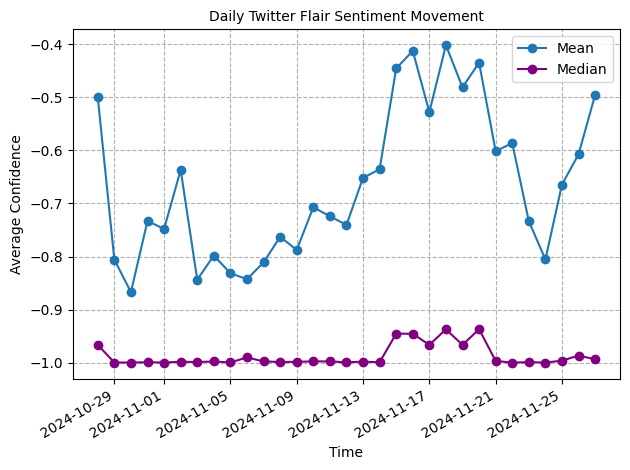

In [80]:
# Plot hourly twitter sentiment movement on **fl_confidence** column
plt.figure()

plt.plot(f_day_mean['time'], f_day_mean['fl_confidence'], marker='o', label='Mean')
plt.plot(f_day_med['time'], f_day_med['fl_confidence'], color='purple', marker='o', label='Median')

plt.title('Daily Twitter Flair Sentiment Movement', fontsize=10)
plt.xlabel('Time')
plt.ylabel('Average Confidence')

plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.legend()
plt.show()

### 2. Visualize Sentiment Values
- For every hour, retrieve the number of "NEGATIVE" and "POSITIVE" from the **sentiment** column.
- Drop any empty data from **sentiment** column.

In [81]:
# For every hour, retrieve the number of "NEGATIVE" and "POSITIVE" from the **sentiment** column.
hr_pos_neg = tw_data.groupby(
    tw_data['time'].dt.floor('h')
)['fl_sentiment'].value_counts(normalize=True).unstack().reset_index().fillna(0)

# Convert fractions to percentages
hr_pos_neg['NEGATIVE'] *= 100
hr_pos_neg['POSITIVE'] *= 100

hr_pos_neg.head(3)

fl_sentiment,time,NEGATIVE,POSITIVE
0,2024-10-28 19:00:00,66.666667,33.333333
1,2024-10-28 20:00:00,80.000000,20.000000
2,2024-10-28 21:00:00,71.428571,28.571429


In [82]:
# Drop any empty data
hr_pos_neg = hr_pos_neg.dropna()

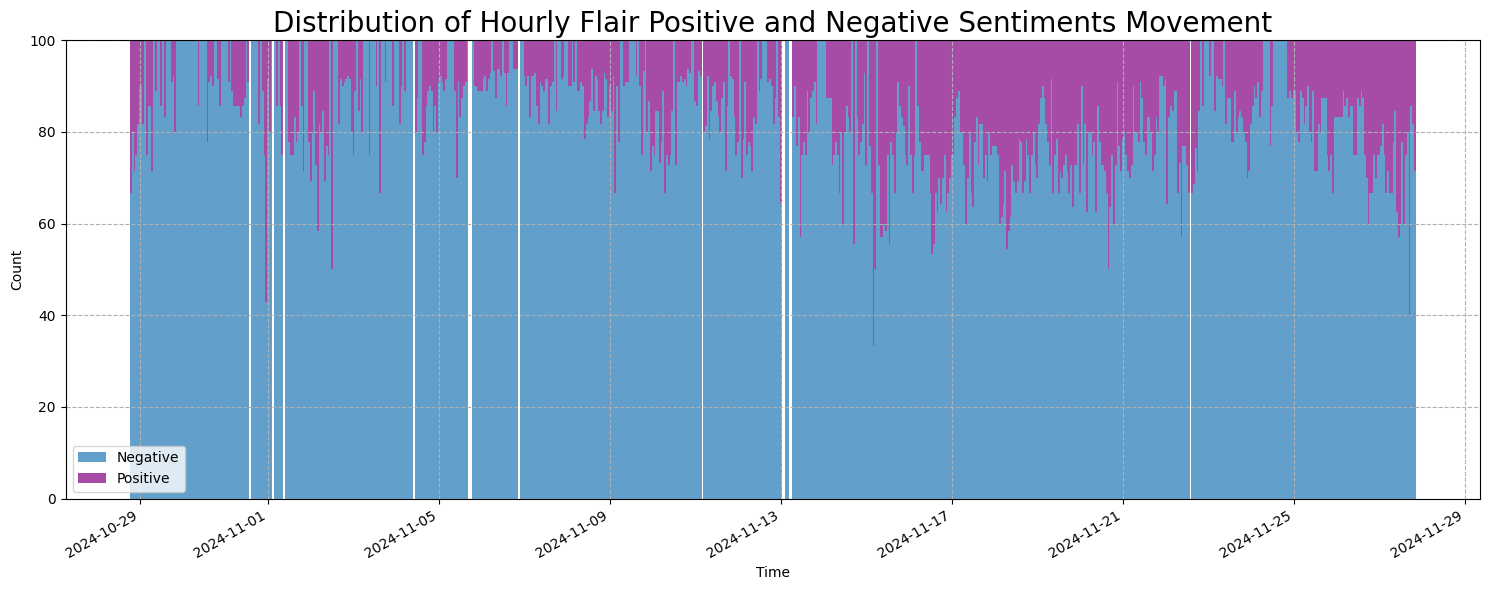

In [83]:
p.positive_negative_distribution_bar(hr_pos_neg['time'], 
  hr_pos_neg['NEGATIVE'], 
  hr_pos_neg['POSITIVE'], 
  1/24, 
  'Distribution of Hourly Flair Positive and Negative Sentiments Movement')

In [ ]:
# For every day, retrieve the number of "NEGATIVE" and "POSITIVE" from the **sentiment** column.
day_pos_neg = tw_data.groupby(
    tw_data['time'].dt.floor('d')
)['fl_sentiment'].value_counts(normalize=True).unstack().reset_index().fillna(0)

# Convert fractions to percentages
day_pos_neg['NEGATIVE'] *= 100
day_pos_neg['POSITIVE'] *= 100

# Drop any empty data
day_pos_neg = day_pos_neg.dropna()

day_pos_neg.head(3)

fl_sentiment,time,NEGATIVE,POSITIVE
0,2024-10-28,74.418605,25.581395
1,2024-10-29,91.707317,8.292683
2,2024-10-30,96.039604,3.960396


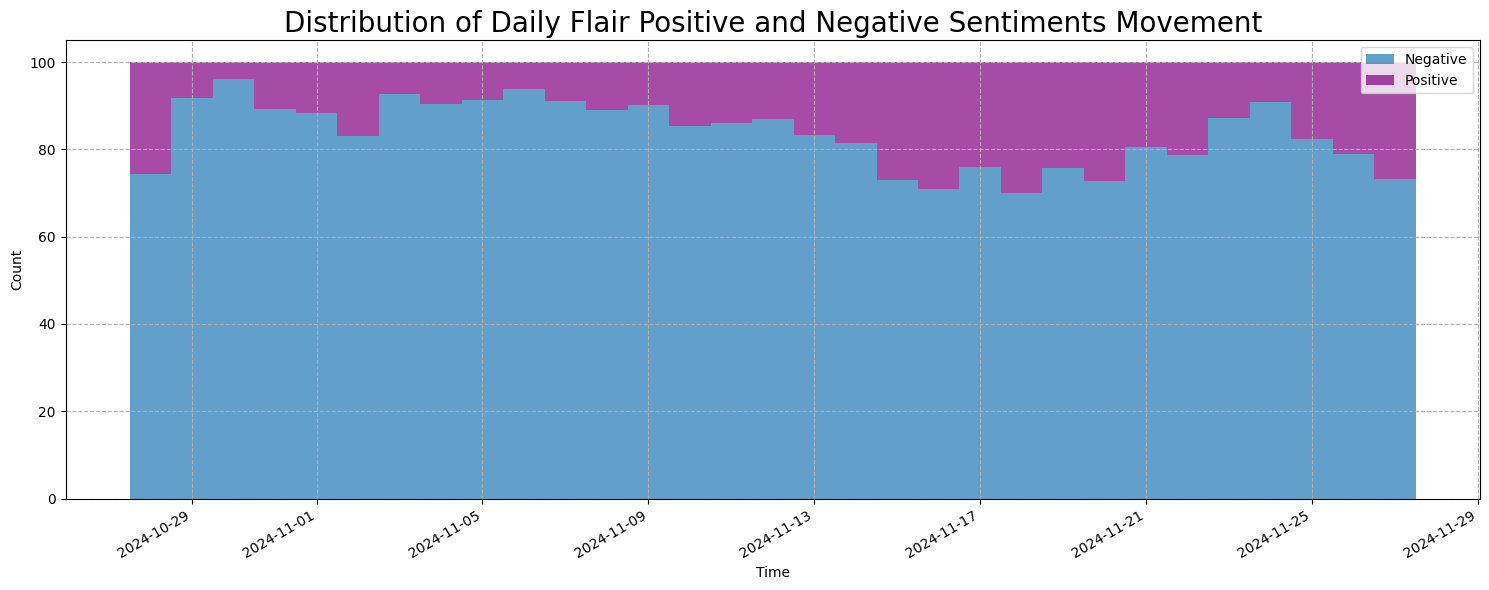

In [86]:
p.positive_negative_distribution_bar(day_pos_neg['time'], 
  day_pos_neg['NEGATIVE'], 
  day_pos_neg['POSITIVE'], 
  1, 
  'Distribution of Daily Flair Positive and Negative Sentiments Movement')

### Visualize VADER Sentiment Movement
- Calculate the mean and median of **confidence** column grouped by each hour.
- Calculate the mean and median of **confidence** column grouped by day.

In [87]:
# Hourly mean
v_hr_mean = tw_data.groupby(
  tw_data['time'].dt.floor('h')
  )[['vd_positive', 'vd_negative', 'vd_neutral', 'vd_compound']].mean().reset_index()

v_hr_mean.head(3)

,time,vd_positive,vd_negative,vd_neutral,vd_compound
0,2024-10-28 19:00:00,0.152583,0.0,0.847417,0.396342
1,2024-10-28 20:00:00,0.127000,0.0,0.873000,0.335760
2,2024-10-28 21:00:00,0.171429,0.0,0.828571,0.444257


In [88]:
# Hourly median
v_hr_med = tw_data.groupby(
  tw_data['time'].dt.floor('h')
  )[['vd_positive', 'vd_negative', 'vd_neutral', 'vd_compound']].median().reset_index()

v_hr_med.head(3)

,time,vd_positive,vd_negative,vd_neutral,vd_compound
0,2024-10-28 19:00:00,0.1835,0.0,0.8165,0.4359
1,2024-10-28 20:00:00,0.1110,0.0,0.8890,0.3612
2,2024-10-28 21:00:00,0.2110,0.0,0.7890,0.4738


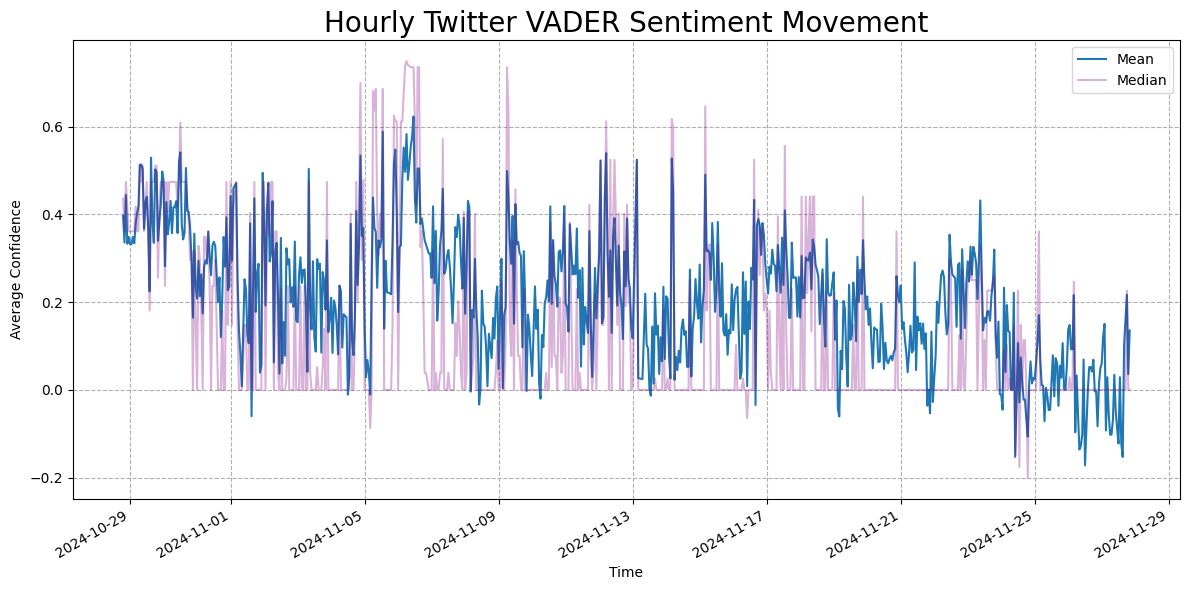

In [89]:
plt.figure(figsize=(12, 6))

plt.plot(v_hr_mean['time'], v_hr_mean['vd_compound'], label='Mean')
plt.plot(v_hr_med['time'], v_hr_med['vd_compound'], color='purple', alpha=0.3, label='Median')

plt.title('Hourly Twitter VADER Sentiment Movement', fontsize=20)
plt.xlabel('Time')
plt.ylabel('Average Confidence')

plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.legend()
plt.show()

In [90]:
# Daily mean
v_day_mean = tw_data.groupby(
  tw_data['time'].dt.floor('d')
  )[['vd_positive', 'vd_negative', 'vd_neutral', 'vd_compound']].mean().reset_index()

v_day_mean.head(3)

,time,vd_positive,vd_negative,vd_neutral,vd_compound
0,2024-10-28,0.141953,0.000000,0.858047,0.373007
1,2024-10-29,0.128927,0.003283,0.867795,0.406499
2,2024-10-30,0.115955,0.003490,0.880579,0.385182


In [91]:
# Daily median
v_day_med = tw_data.groupby(
  tw_data['time'].dt.floor('d')
  )[['vd_positive', 'vd_negative', 'vd_neutral', 'vd_compound']].median().reset_index()

v_day_med.head(3)

,time,vd_positive,vd_negative,vd_neutral,vd_compound
0,2024-10-28,0.161,0.0,0.839,0.4466
1,2024-10-29,0.123,0.0,0.877,0.4738
2,2024-10-30,0.118,0.0,0.882,0.4738


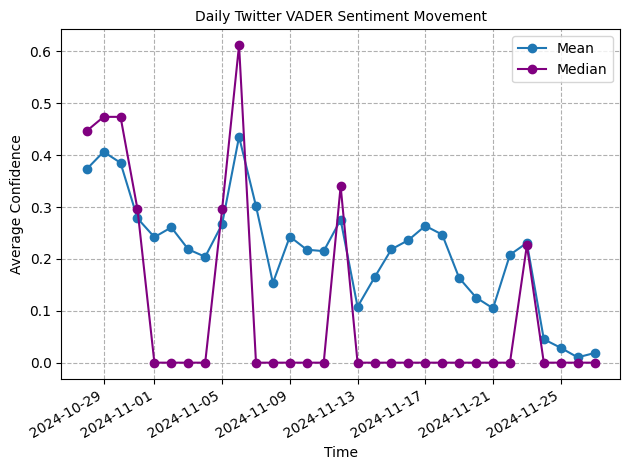

In [92]:
plt.figure()

plt.plot(v_day_mean['time'], v_day_mean['vd_compound'], marker='o', label='Mean')
plt.plot(v_day_med['time'], v_day_med['vd_compound'], color='purple',  marker='o', label='Median')

plt.title('Daily Twitter VADER Sentiment Movement', fontsize=10)
plt.xlabel('Time')
plt.ylabel('Average Confidence')

plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.legend()
plt.show()

### Visualize both Sentiment Movements

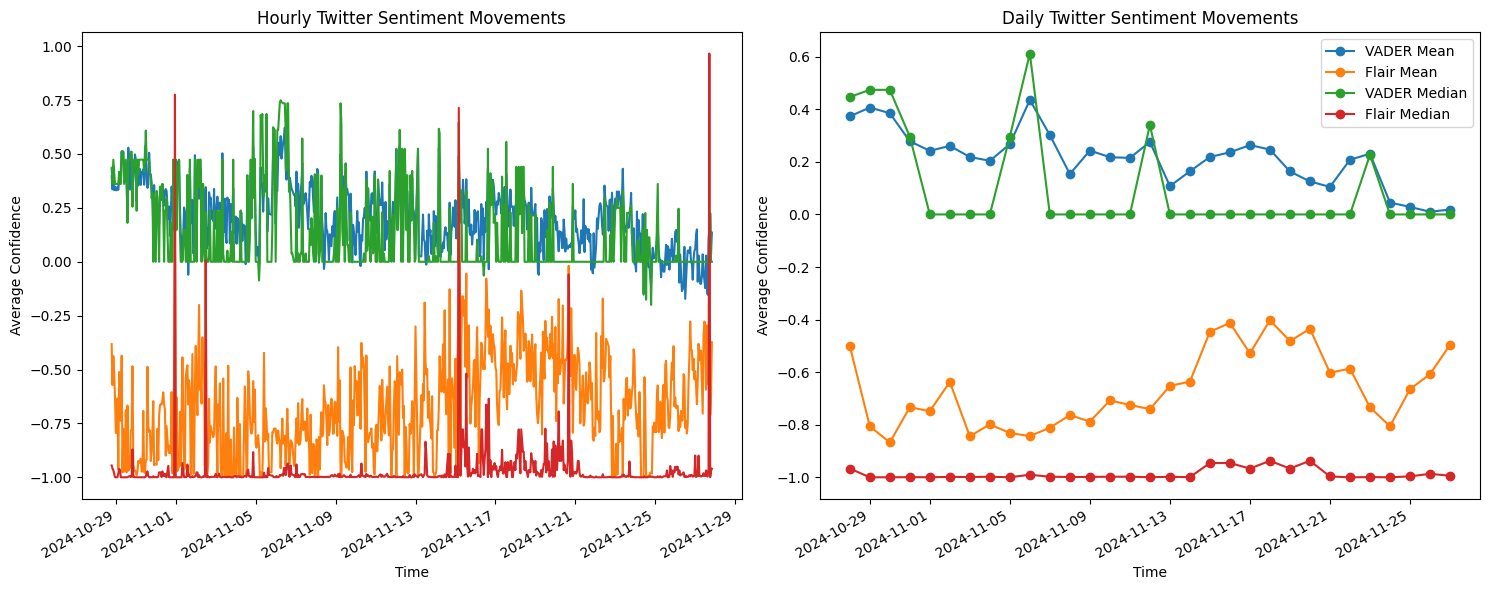

In [40]:
# Twitter sentiment movements through time
f, ax = plt.subplots(1, 2, figsize=(15, 6))

ax[0].plot(v_hr_mean['time'], v_hr_mean['vd_compound'], label='VADER Mean')
ax[0].plot(f_hr_mean['time'], f_hr_mean['fl_confidence'], label='Flair Mean')
ax[0].plot(v_hr_med['time'], v_hr_med['vd_compound'], label='VADER Median')
ax[0].plot(f_hr_med['time'], f_hr_med['fl_confidence'], label='Flair Median')
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Average Confidence")
ax[0].set_title("Hourly Twitter Sentiment Movements")

ax[1].plot(v_day_mean['time'], v_day_mean['vd_compound'], marker='o', label='VADER Mean')
ax[1].plot(f_day_mean['time'], f_day_mean['fl_confidence'], marker='o', label='Flair Mean')
ax[1].plot(v_day_med['time'], v_day_med['vd_compound'], marker='o', label='VADER Median')
ax[1].plot(f_day_med['time'], f_day_med['fl_confidence'], marker='o', label='Flair Median')
ax[1].set_xlabel("Time")
ax[1].set_ylabel("Average Confidence")
ax[1].set_title("Daily Twitter Sentiment Movements")

plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.legend()
plt.show()

## Find Correlation between Bitcoin Price Movemnent VS. Twitter Sentiment

In [158]:
# Load the hourly dataset
btc_data = pd.read_csv('hourly_btc_tw_data.csv')

# Convert 'time' to datetime
btc_data['time'] = pd.to_datetime(btc_data['time'])
btc_data.head(3)

,timestamp,symbol,name,price,dayHigh,dayLow,volume,open,close,time,...,BB_middle,BB_upper,BB_lower,RSI,MACD,Signal_Line,MACD_Histogram,volatility,Doji,Hammer
0,2024-10-28 16:14:23,BTC,Bitcoin USD,68720.00,69299.0,67532.48,2.338602e+10,67939.54,67939.54,2024-10-28 16:00:00,...,68720.00,NaN,NaN,50.0,0.000000,0.000000,0.000000,NaN,True,False
1,2024-10-28 17:29:02,BTC,Bitcoin USD,68862.88,69299.0,67532.48,2.338602e+10,67939.54,67939.54,2024-10-28 17:00:00,...,68791.44,68993.502834,68589.377166,100.0,11.397835,2.279567,9.118268,NaN,True,False
2,2024-10-28 17:33:29,BTC,Bitcoin USD,69086.55,69299.0,67532.48,2.338602e+10,67939.54,67939.54,2024-10-28 17:00:00,...,68889.81,69259.315855,68520.304145,100.0,38.040494,9.431752,28.608741,0.082653,True,False


In [159]:
# Resample to daily intervals and calculate required metrics
day_btc = btc_data.resample('D', on='time').agg({
    'price': ['first', 'last', 'mean'],  # Open, Close, and Average Price
    'volume': 'sum',                     # Total Volume
    'dayHigh': 'max',                    # Daily High Price
    'dayLow': 'min',                     # Daily Low Price
    'SMA_5': 'mean',                     # Average SMA_5
    'SMA_10': 'mean',                    # Average SMA_10
    'RSI': 'mean',                       # Average RSI
    'MACD': 'last',                      # Last MACD Value of the Day
    'Signal_Line': 'last',               # Last Signal Line of the Day
    'MACD_Histogram': 'last'             # Last MACD Histogram of the Day
}).reset_index()

# Fix for multi-level columns
day_btc.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in day_btc.columns]

# Reformat column names
day_btc = day_btc.rename(columns={
    'time_': 'time',
    'price_first': 'open',
    'price_last': 'close',
    'price_mean': 'price',
    'volume_sum': 'volume',
    'dayHigh_max': 'dayHigh',
    'dayLow_min': 'dayLow',
    'SMA_5_mean': 'SMA_5',
    'SMA_10_mean': 'SMA_10',
    'RSI_mean': 'RSI',
    'MACD_last': 'MACD',
    'Signal_Line_last': 'Signal_Line',
    'MACD_Histogram_last': 'MACD_Histogram'
})

# Display the first few rows of the resampled daily data
print("\nFirst few rows:")
print(day_btc.head())

# Check the data types and missing values
print("\nDataset Info:")
print(day_btc.info())

print("\nMissing Values:")
print(day_btc.isnull().sum())

# Save the daily data to a CSV file
day_btc.to_csv('day_btc_data.csv', index=False)


First few rows:
        time      open     close         price        volume   dayHigh  \
0 2024-10-28  68720.00  70051.00  69289.377500  2.938971e+11  70288.00   
1 2024-10-29  69752.42  72607.98  71537.300417  1.092847e+12  73624.98   
2 2024-10-30  72508.29  72515.00  72240.830417  1.336778e+12  73624.98   
3 2024-10-31  72364.69  70327.64  71540.485417  1.027684e+12  73060.00   
4 2024-11-01  70279.98  69493.18  69668.325833  1.174492e+12  72684.02   

     dayLow         SMA_5        SMA_10        RSI        MACD  Signal_Line  \
0  67532.48  69101.052000  69016.264981  80.582935  282.484373   156.474843   
1  67532.48  71326.418000  70980.873500  74.479081  713.869070   715.268277   
2  69705.76  72238.347000  72298.577625  48.791275  137.377439   137.749967   
3  69559.33  71730.912583  71912.237500  39.340133 -538.661435  -394.367773   
4  68720.00  69737.412583  69838.189583  41.376214 -312.413866  -316.362537   

   MACD_Histogram  
0      126.009530  
1       -1.399207  
2  

### Create Datasets on BTC Data and Sentiment Data
### 1. Preprocess Hourly Mean and Median Data

In [160]:
# Merge hourly btc_data with tw_data using sentiment mean values
df = pd.merge(hr_btc, v_hr_mean, on='time')
hr_btc_tw = pd.merge(df, f_hr_mean, on='time')

hr_btc_tw = hr_btc_tw.rename(columns={
  "vd_positive": "vd_positive_mean",
  'vd_neutral': "vd_neutral_mean",
  "vd_negative": "vd_negative_mean",
  "vd_compound": "vd_compound_mean",
  "fl_confidence": "fl_confidence_mean",
})

hr_btc_tw.head(3)

,symbol,name,price,dayHigh,dayLow,volume,open,close,time,SMA_5,...,Signal_Line,MACD_Histogram,volatility,Doji,Hammer,vd_positive_mean,vd_negative_mean,vd_neutral_mean,vd_compound_mean,fl_confidence_mean
0,BTC,Bitcoin USD,69376.60,69529.0,67532.48,2.338602e+10,67939.54,67939.54,2024-10-28 19:00:00,69103.222,...,59.863536,46.975034,0.318658,True,False,0.152583,0.0,0.847417,0.396342,-0.382009
1,BTC,Bitcoin USD,69438.00,70000.0,67532.48,2.338602e+10,67939.54,67939.54,2024-10-28 20:00:00,69156.300,...,75.051001,60.749859,0.295505,True,False,0.127000,0.0,0.873000,0.335760,-0.571712
2,BTC,Bitcoin USD,69741.99,70000.0,67532.48,2.338602e+10,67939.54,67939.54,2024-10-28 21:00:00,69274.376,...,96.279689,84.914751,0.294800,True,False,0.171429,0.0,0.828571,0.444257,-0.437302


In [161]:
# Merge hourly btc_data with tw_data using sentiment median values
df = pd.merge(hr_btc_tw, v_hr_med, on='time')
hr_btc_tw = pd.merge(df, f_hr_med, on='time')

# Rename columns
hr_btc_tw = hr_btc_tw.rename(columns={
  "vd_positive": "vd_positive_med",
  'vd_neutral': "vd_neutral_med",
  "vd_negative": "vd_negative_med",
  "vd_compound": "vd_compound_med",
  "fl_confidence": "fl_confidence_med",
})

hr_btc_tw.head(3)

,symbol,name,price,dayHigh,dayLow,volume,open,close,time,SMA_5,...,vd_positive_mean,vd_negative_mean,vd_neutral_mean,vd_compound_mean,fl_confidence_mean,vd_positive_med,vd_negative_med,vd_neutral_med,vd_compound_med,fl_confidence_med
0,BTC,Bitcoin USD,69376.60,69529.0,67532.48,2.338602e+10,67939.54,67939.54,2024-10-28 19:00:00,69103.222,...,0.152583,0.0,0.847417,0.396342,-0.382009,0.1835,0.0,0.8165,0.4359,-0.944707
1,BTC,Bitcoin USD,69438.00,70000.0,67532.48,2.338602e+10,67939.54,67939.54,2024-10-28 20:00:00,69156.300,...,0.127000,0.0,0.873000,0.335760,-0.571712,0.1110,0.0,0.8890,0.3612,-0.959424
2,BTC,Bitcoin USD,69741.99,70000.0,67532.48,2.338602e+10,67939.54,67939.54,2024-10-28 21:00:00,69274.376,...,0.171429,0.0,0.828571,0.444257,-0.437302,0.2110,0.0,0.7890,0.4738,-0.966333


In [ ]:
# Merge hourly btc_data with positive / negative proportion values
hr_btc_tw = pd.merge(hr_btc_tw, hr_pos_neg, on="time")

hr_btc_tw.head(3)

,symbol,name,price,dayHigh,dayLow,volume,open,close,time,SMA_5,...,fl_confidence_med,NEGATIVE_x,POSITIVE_x,price_delta,fl_confidence_mean_delta,vd_compound_mean_delta,fl_confidence_med_delta,vd_compound_med_delta,NEGATIVE_y,POSITIVE_y
0,BTC,Bitcoin USD,69376.60,69529.0,67532.48,2.338602e+10,67939.54,67939.54,2024-10-28 19:00:00,69103.222,...,-0.944707,66.666667,33.333333,NaN,NaN,NaN,NaN,NaN,66.666667,33.333333
1,BTC,Bitcoin USD,69438.00,70000.0,67532.48,2.338602e+10,67939.54,67939.54,2024-10-28 20:00:00,69156.300,...,-0.959424,80.000000,20.000000,61.40,-0.189703,-0.060582,-0.014717,-0.0747,80.000000,20.000000
2,BTC,Bitcoin USD,69741.99,70000.0,67532.48,2.338602e+10,67939.54,67939.54,2024-10-28 21:00:00,69274.376,...,-0.966333,71.428571,28.571429,303.99,0.134410,0.108497,-0.006909,0.1126,71.428571,28.571429


In [165]:
# Add delta columns on **Price**, **fl_confidence** and **vd_compound** columns
hr_btc_tw['price_delta'] = hr_btc_tw['price'].diff()
hr_btc_tw['fl_confidence_mean_delta'] = hr_btc_tw['fl_confidence_mean'].diff()
hr_btc_tw['vd_compound_mean_delta'] = hr_btc_tw['vd_compound_mean'].diff()
hr_btc_tw['fl_confidence_med_delta'] = hr_btc_tw['fl_confidence_med'].diff()
hr_btc_tw['vd_compound_med_delta'] = hr_btc_tw['vd_compound_med'].diff()
hr_btc_tw['POSITIVE_delta'] = hr_btc_tw['POSITIVE_y'].diff()

hr_btc_tw.head(3)

,symbol,name,price,dayHigh,dayLow,volume,open,close,time,SMA_5,...,NEGATIVE_x,POSITIVE_x,price_delta,fl_confidence_mean_delta,vd_compound_mean_delta,fl_confidence_med_delta,vd_compound_med_delta,NEGATIVE_y,POSITIVE_y,POSITIVE_delta
0,BTC,Bitcoin USD,69376.60,69529.0,67532.48,2.338602e+10,67939.54,67939.54,2024-10-28 19:00:00,69103.222,...,66.666667,33.333333,NaN,NaN,NaN,NaN,NaN,66.666667,33.333333,NaN
1,BTC,Bitcoin USD,69438.00,70000.0,67532.48,2.338602e+10,67939.54,67939.54,2024-10-28 20:00:00,69156.300,...,80.000000,20.000000,61.40,-0.189703,-0.060582,-0.014717,-0.0747,80.000000,20.000000,-13.333333
2,BTC,Bitcoin USD,69741.99,70000.0,67532.48,2.338602e+10,67939.54,67939.54,2024-10-28 21:00:00,69274.376,...,71.428571,28.571429,303.99,0.134410,0.108497,-0.006909,0.1126,71.428571,28.571429,8.571429


In [166]:
hr_btc_tw = hr_btc_tw.dropna()

hr_btc_tw.to_csv("hour_btc_tw.csv")

### 2. Preprocess Daily Mean and Median Data

In [167]:
# Merge daily btc_data with tw_data using sentiment mean values
df = pd.merge(day_btc, v_day_mean, on='time')
day_btc_tw = pd.merge(df, f_day_mean, on='time')

day_btc_tw = day_btc_tw.rename(columns={
  "vd_positive": "vd_positive_mean",
  'vd_neutral': "vd_neutral_mean",
  "vd_negative": "vd_negative_mean",
  "vd_compound": "vd_compound_mean",
  "fl_confidence": "fl_confidence_mean",
})

day_btc_tw.head(3)

,time,open,close,price,volume,dayHigh,dayLow,SMA_5,SMA_10,RSI,MACD,Signal_Line,MACD_Histogram,vd_positive_mean,vd_negative_mean,vd_neutral_mean,vd_compound_mean,fl_confidence_mean
0,2024-10-28,68720.00,70051.00,69289.377500,2.938971e+11,70288.00,67532.48,69101.052,69016.264981,80.582935,282.484373,156.474843,126.009530,0.141953,0.000000,0.858047,0.373007,-0.500137
1,2024-10-29,69752.42,72607.98,71537.300417,1.092847e+12,73624.98,67532.48,71326.418,70980.873500,74.479081,713.869070,715.268277,-1.399207,0.128927,0.003283,0.867795,0.406499,-0.805778
2,2024-10-30,72508.29,72515.00,72240.830417,1.336778e+12,73624.98,69705.76,72238.347,72298.577625,48.791275,137.377439,137.749967,-0.372528,0.115955,0.003490,0.880579,0.385182,-0.867068


In [168]:
# Merge btc_data with tw_data using sentiment median values
df = pd.merge(day_btc_tw, v_hr_med, on='time')
day_btc_tw = pd.merge(df, f_hr_med, on='time')

# Rename columns
day_btc_tw = day_btc_tw.rename(columns={
  "vd_positive": "vd_positive_med",
  'vd_neutral': "vd_neutral_med",
  "vd_negative": "vd_negative_med",
  "vd_compound": "vd_compound_med",
  "fl_confidence": "fl_confidence_med",
})

day_btc_tw.head(3)

,time,open,close,price,volume,dayHigh,dayLow,SMA_5,SMA_10,RSI,...,vd_positive_mean,vd_negative_mean,vd_neutral_mean,vd_compound_mean,fl_confidence_mean,vd_positive_med,vd_negative_med,vd_neutral_med,vd_compound_med,fl_confidence_med
0,2024-10-29,69752.42,72607.98,71537.300417,1.092847e+12,73624.98,67532.48,71326.418000,70980.873500,74.479081,...,0.128927,0.003283,0.867795,0.406499,-0.805778,0.117,0.0,0.883,0.3612,-0.999337
1,2024-10-30,72508.29,72515.00,72240.830417,1.336778e+12,73624.98,69705.76,72238.347000,72298.577625,48.791275,...,0.115955,0.003490,0.880579,0.385182,-0.867068,0.142,0.0,0.858,0.4738,-0.999265
2,2024-10-31,72364.69,70327.64,71540.485417,1.027684e+12,73060.00,69559.33,71730.912583,71912.237500,39.340133,...,0.100577,0.014857,0.884565,0.278284,-0.733011,0.000,0.0,1.000,0.0000,-0.999045


In [169]:
# Merge daily btc_data with positive / negative proportion values
day_btc_tw = pd.merge(day_btc_tw, day_pos_neg, on="time")

In [170]:
# Add delta columns on **Price**, **fl_confidence** and **vd_compound** columns
day_btc_tw['price_delta'] = day_btc_tw['price'].diff()
day_btc_tw['fl_confidence_mean_delta'] = day_btc_tw['fl_confidence_mean'].diff()
day_btc_tw['vd_compound_mean_delta'] = day_btc_tw['vd_compound_mean'].diff()
day_btc_tw['fl_confidence_med_delta'] = day_btc_tw['fl_confidence_med'].diff()
day_btc_tw['vd_compound_med_delta'] = day_btc_tw['vd_compound_med'].diff()
day_btc_tw['POSITIVE_delta'] = day_btc_tw['POSITIVE'].diff()

day_btc_tw.head(3)

,time,open,close,price,volume,dayHigh,dayLow,SMA_5,SMA_10,RSI,...,vd_compound_med,fl_confidence_med,NEGATIVE,POSITIVE,price_delta,fl_confidence_mean_delta,vd_compound_mean_delta,fl_confidence_med_delta,vd_compound_med_delta,POSITIVE_delta
0,2024-10-29,69752.42,72607.98,71537.300417,1.092847e+12,73624.98,67532.48,71326.418000,70980.873500,74.479081,...,0.3612,-0.999337,91.707317,8.292683,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-10-30,72508.29,72515.00,72240.830417,1.336778e+12,73624.98,69705.76,72238.347000,72298.577625,48.791275,...,0.4738,-0.999265,96.039604,3.960396,703.530,-0.061290,-0.021317,0.000072,0.1126,-4.332287
2,2024-10-31,72364.69,70327.64,71540.485417,1.027684e+12,73060.00,69559.33,71730.912583,71912.237500,39.340133,...,0.0000,-0.999045,89.285714,10.714286,-700.345,0.134057,-0.106898,0.000220,-0.4738,6.753890


In [171]:
# Save the daily data to a CSV file if needed
day_btc_tw = day_btc_tw.dropna()
day_btc_tw.to_csv('day_btc_tw.csv', index=False)

### 2. Visualize Correlations between Different Factors

In [3]:
hr_btc_tw = pd.read_csv('hour_btc_tw.csv')
hr_btc_tw['time'] = pd.to_datetime(hr_btc_tw['time'])

day_btc_tw = pd.read_csv('day_btc_tw.csv')
day_btc_tw['time'] = pd.to_datetime(day_btc_tw['time'])

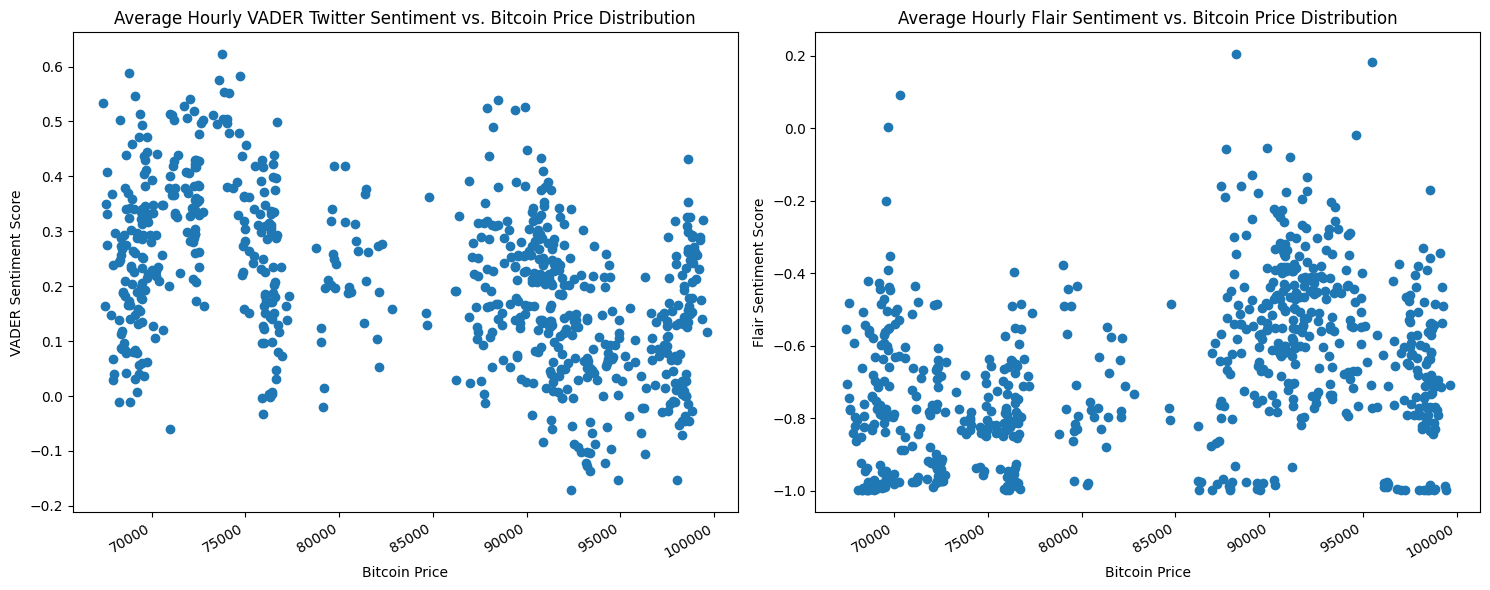

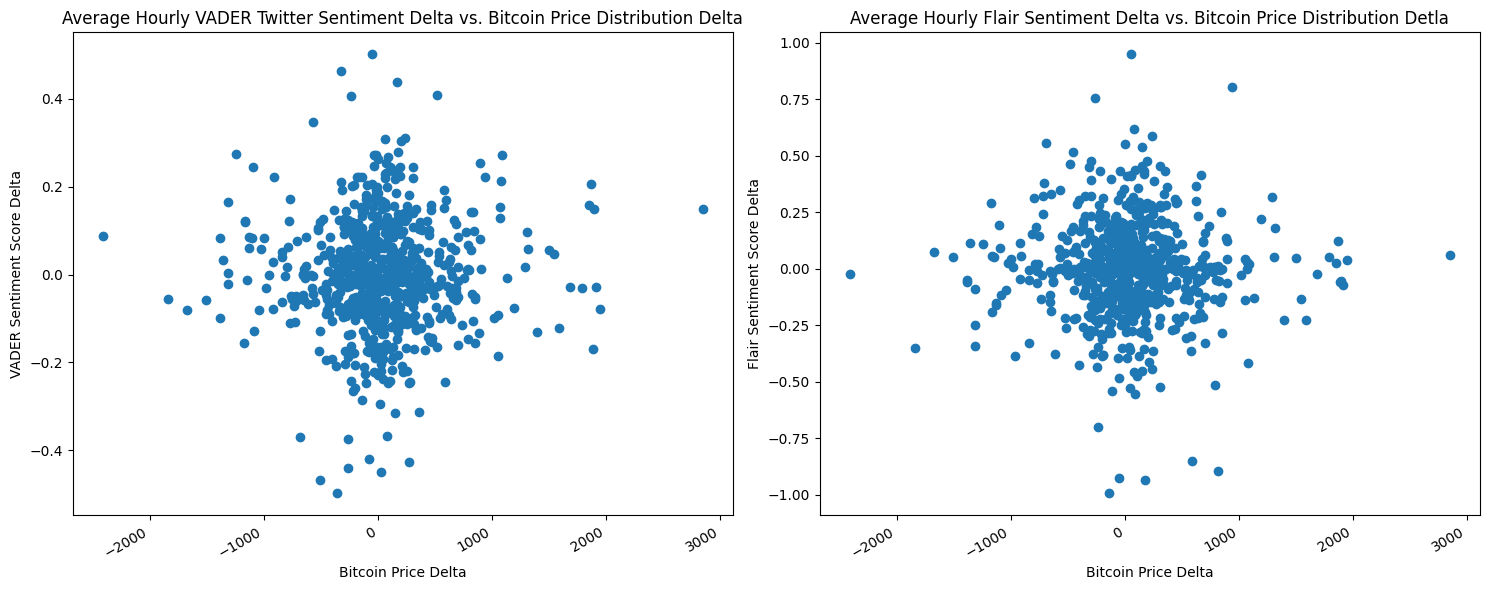

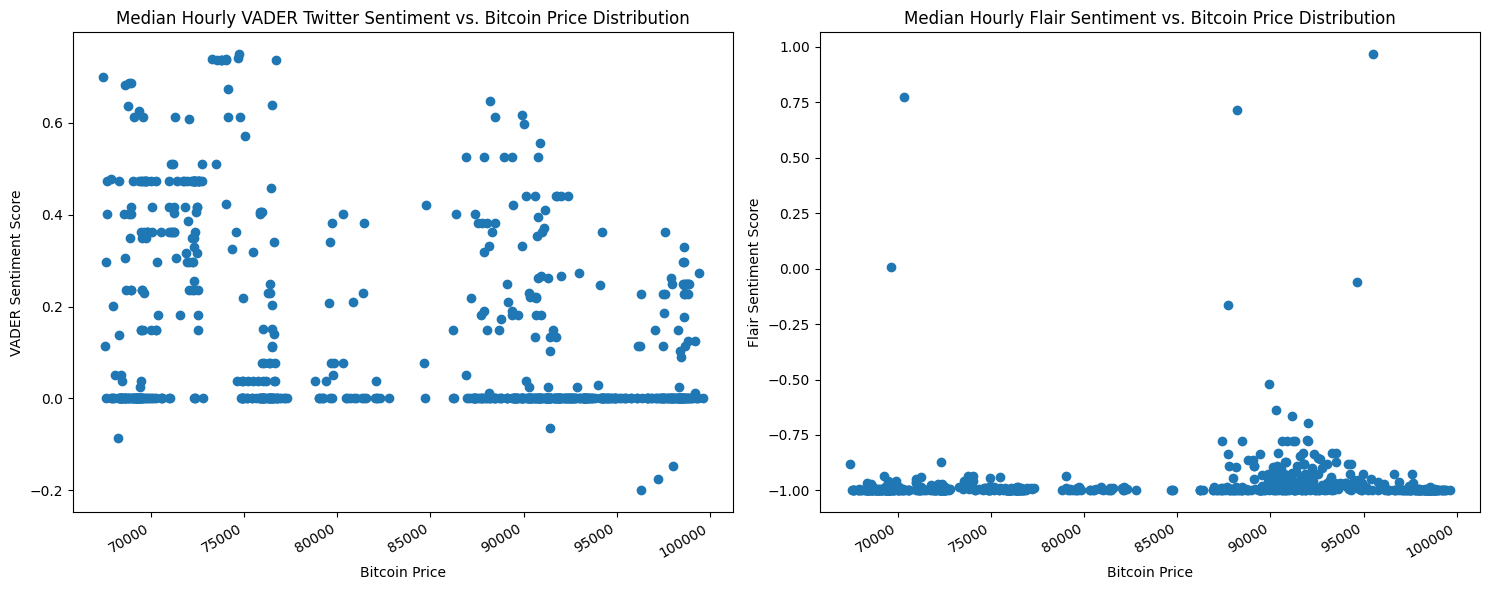

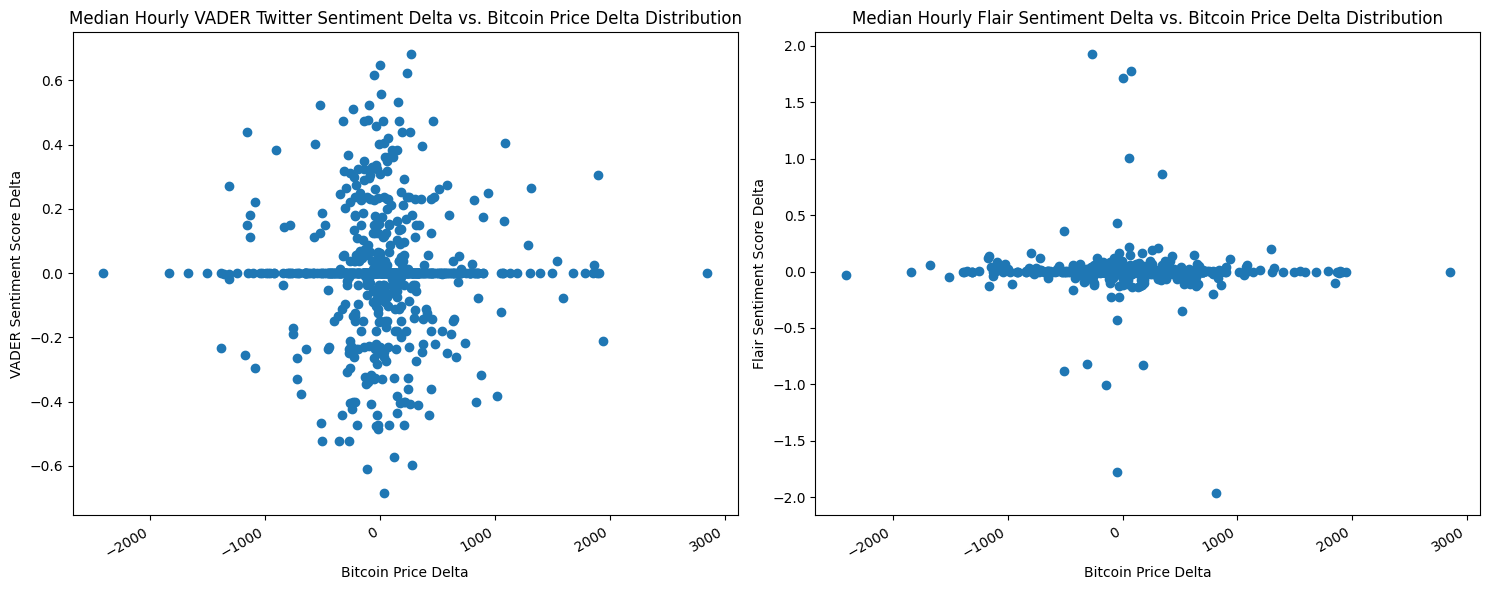

In [4]:
# Draw scatter plot to visualize correlation between mean hourly price vs. mean hourly Twitter sentiment
p.sentiment_price_scatter(hr_btc_tw['price'], hr_btc_tw['vd_compound_mean'], hr_btc_tw['fl_confidence_mean'], 
  "Average Hourly VADER Twitter Sentiment vs. Bitcoin Price Distribution","Bitcoin Price","VADER Sentiment Score",
  "Average Hourly Flair Sentiment vs. Bitcoin Price Distribution", "Bitcoin Price", "Flair Sentiment Score")

# Draw scatter plot to visualize correlation between mean hourly price delta vs. mean hourly Twitter sentiment delta
p.sentiment_price_scatter(hr_btc_tw['price_delta'], hr_btc_tw['vd_compound_mean_delta'], hr_btc_tw['fl_confidence_mean_delta'], 
  "Average Hourly VADER Twitter Sentiment Delta vs. Bitcoin Price Distribution Delta","Bitcoin Price Delta","VADER Sentiment Score Delta",
  "Average Hourly Flair Sentiment Delta vs. Bitcoin Price Distribution Detla", "Bitcoin Price Delta", "Flair Sentiment Score Delta")

# Draw scatter plot to visualize correlation between median hourly price delta vs. median hourly Twitter sentiment delta
p.sentiment_price_scatter(hr_btc_tw['price'], hr_btc_tw['vd_compound_med'], hr_btc_tw['fl_confidence_med'], 
  "Median Hourly VADER Twitter Sentiment vs. Bitcoin Price Distribution","Bitcoin Price","VADER Sentiment Score",
  "Median Hourly Flair Sentiment vs. Bitcoin Price Distribution", "Bitcoin Price", "Flair Sentiment Score")

# Draw scatter plot to visualize correlation between median hourly price delta vs. median hourly Twitter sentiment delta
p.sentiment_price_scatter(hr_btc_tw['price_delta'], hr_btc_tw['vd_compound_med_delta'], hr_btc_tw['fl_confidence_med_delta'], 
  "Median Hourly VADER Twitter Sentiment Delta vs. Bitcoin Price Delta Distribution","Bitcoin Price Delta","VADER Sentiment Score Delta",
  "Median Hourly Flair Sentiment Delta vs. Bitcoin Price Delta Distribution", "Bitcoin Price Delta", "Flair Sentiment Score Delta")

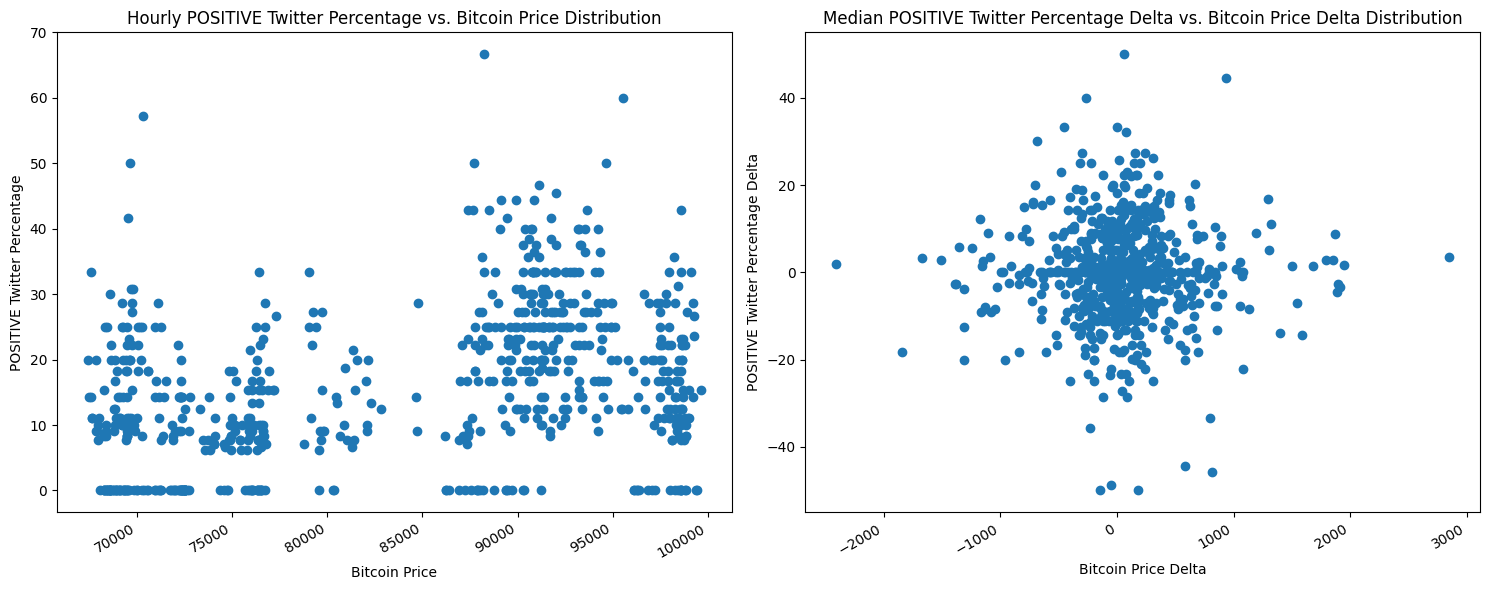

In [ ]:
# Draw scatter plot to visualize correlation between hourly price vs. POSITIVE twitter percentage
p.sentiment_price_delta_scatter(hr_btc_tw['price'], hr_btc_tw['price_delta'], hr_btc_tw['POSITIVE_x'], hr_btc_tw['POSITIVE_delta'], 
  "Hourly FLAIR POSITIVE Twitter Percentage vs. Bitcoin Price Distribution","Bitcoin Price","POSITIVE Twitter Percentage",
  "Hourly FLAIR POSITIVE Twitter Percentage Delta vs. Bitcoin Price Delta Distribution", "Bitcoin Price Delta", "POSITIVE Twitter Percentage Delta")

### Daily Mean and Median Data

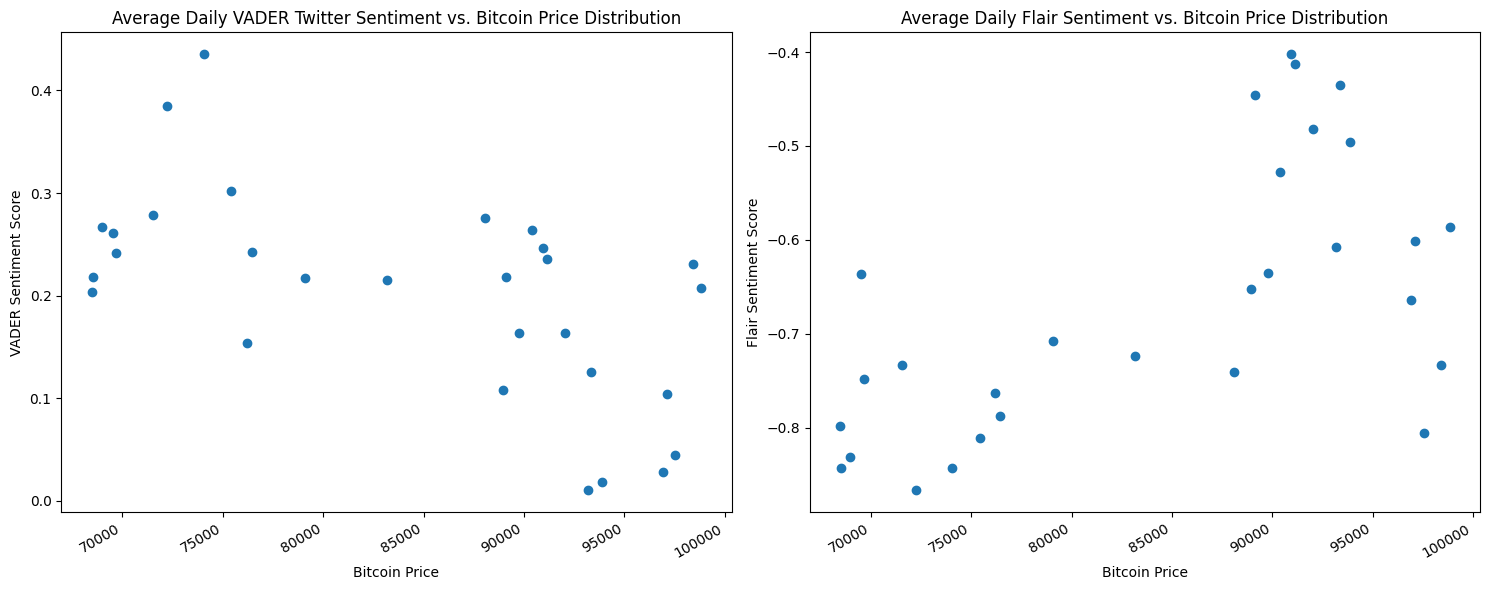

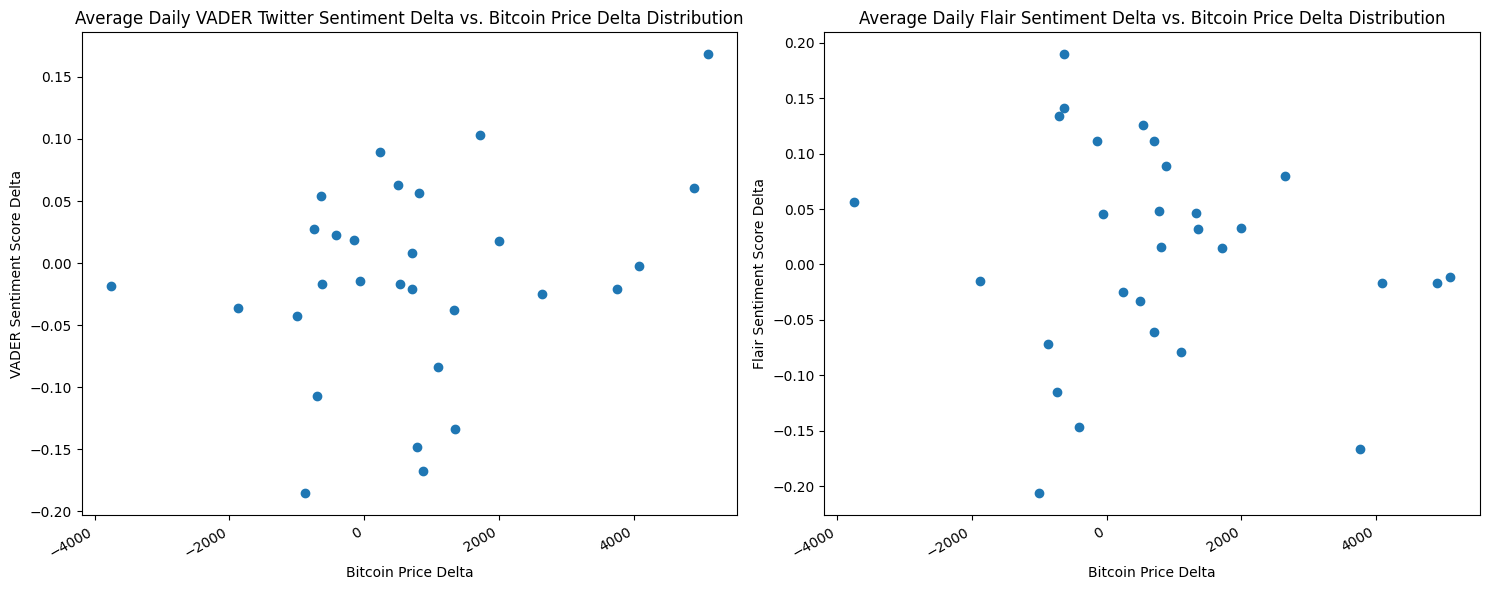

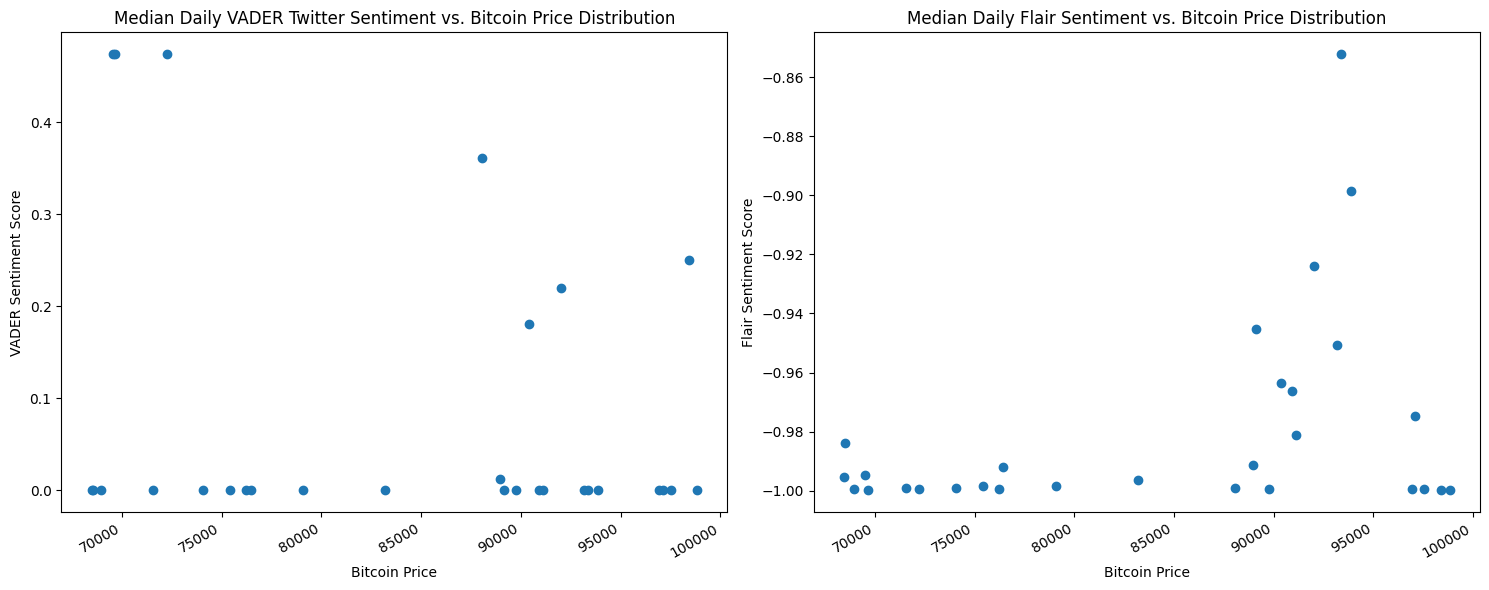

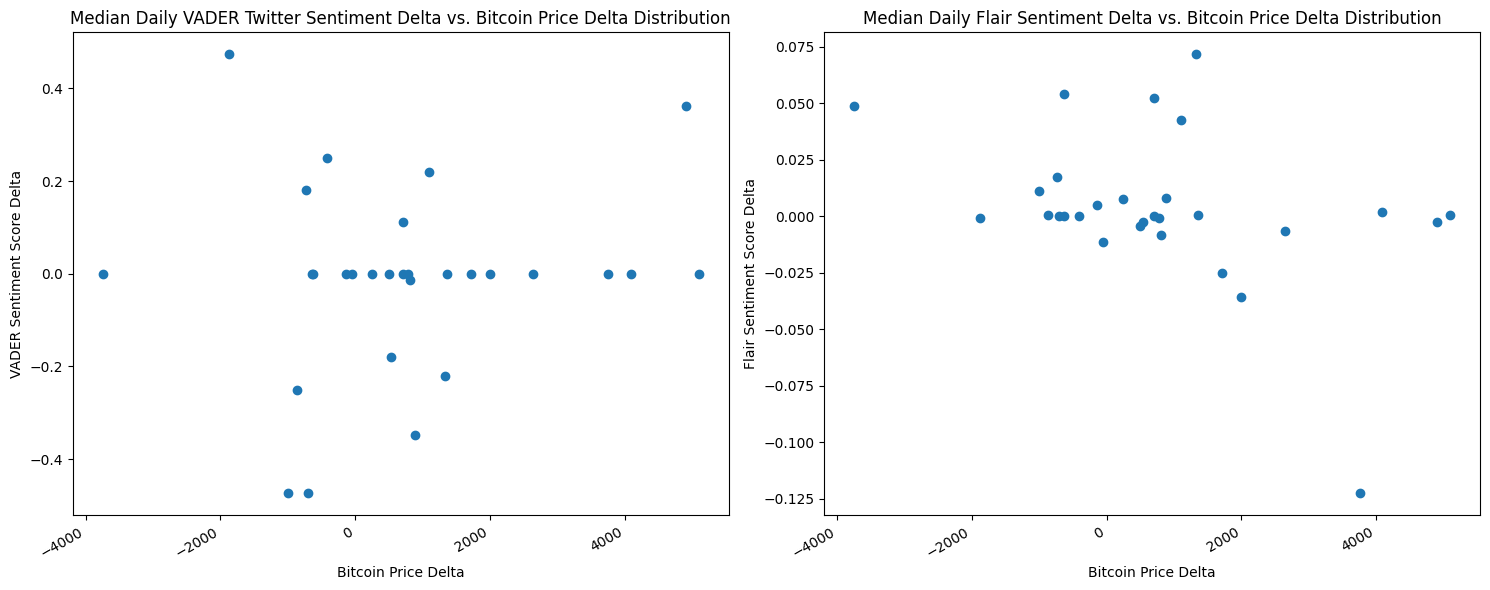

In [6]:
# Draw scatter plot to visualize correlation between median daily price vs. median daily Twitter sentiment
p.sentiment_price_scatter(day_btc_tw['price'], day_btc_tw['vd_compound_mean'], day_btc_tw['fl_confidence_mean'], 
  "Average Daily VADER Twitter Sentiment vs. Bitcoin Price Distribution","Bitcoin Price","VADER Sentiment Score",
  "Average Daily Flair Sentiment vs. Bitcoin Price Distribution", "Bitcoin Price", "Flair Sentiment Score")

  # Draw scatter plot to visualize correlation between mean daily price delta vs. mean daily Twitter sentiment delta
p.sentiment_price_scatter(day_btc_tw['price_delta'], day_btc_tw['vd_compound_mean_delta'], day_btc_tw['fl_confidence_mean_delta'], 
  "Average Daily VADER Twitter Sentiment Delta vs. Bitcoin Price Delta Distribution","Bitcoin Price Delta","VADER Sentiment Score Delta",
  "Average Daily Flair Sentiment Delta vs. Bitcoin Price Delta Distribution", "Bitcoin Price Delta", "Flair Sentiment Score Delta")

  # Draw scatter plot to visualize correlation between median daily price vs. median daily Twitter sentiment
p.sentiment_price_scatter(day_btc_tw['price'], day_btc_tw['vd_compound_med'], day_btc_tw['fl_confidence_med'], 
  "Median Daily VADER Twitter Sentiment vs. Bitcoin Price Distribution","Bitcoin Price","VADER Sentiment Score",
  "Median Daily Flair Sentiment vs. Bitcoin Price Distribution", "Bitcoin Price", "Flair Sentiment Score")

# Draw scatter plot to visualize correlation between median daily price delta vs. median daily Twitter sentiment delta
p.sentiment_price_scatter(day_btc_tw['price_delta'], day_btc_tw['vd_compound_med_delta'], day_btc_tw['fl_confidence_med_delta'], 
  "Median Daily VADER Twitter Sentiment Delta vs. Bitcoin Price Delta Distribution","Bitcoin Price Delta","VADER Sentiment Score Delta",
  "Median Daily Flair Sentiment Delta vs. Bitcoin Price Delta Distribution", "Bitcoin Price Delta", "Flair Sentiment Score Delta")

## Daily Max/Min Price Values VS. Daily Twitter Sentiment 

In [7]:
# Add delta columns on **dayHigh**, **dayLow** and **vd_compound** columns
day_btc_tw['dayHigh_delta'] = day_btc_tw['dayHigh'].diff()
day_btc_tw['dayLow_delta'] = day_btc_tw['dayLow'].diff()

# Drop any empty data
day_btc_tw = day_btc_tw.dropna()

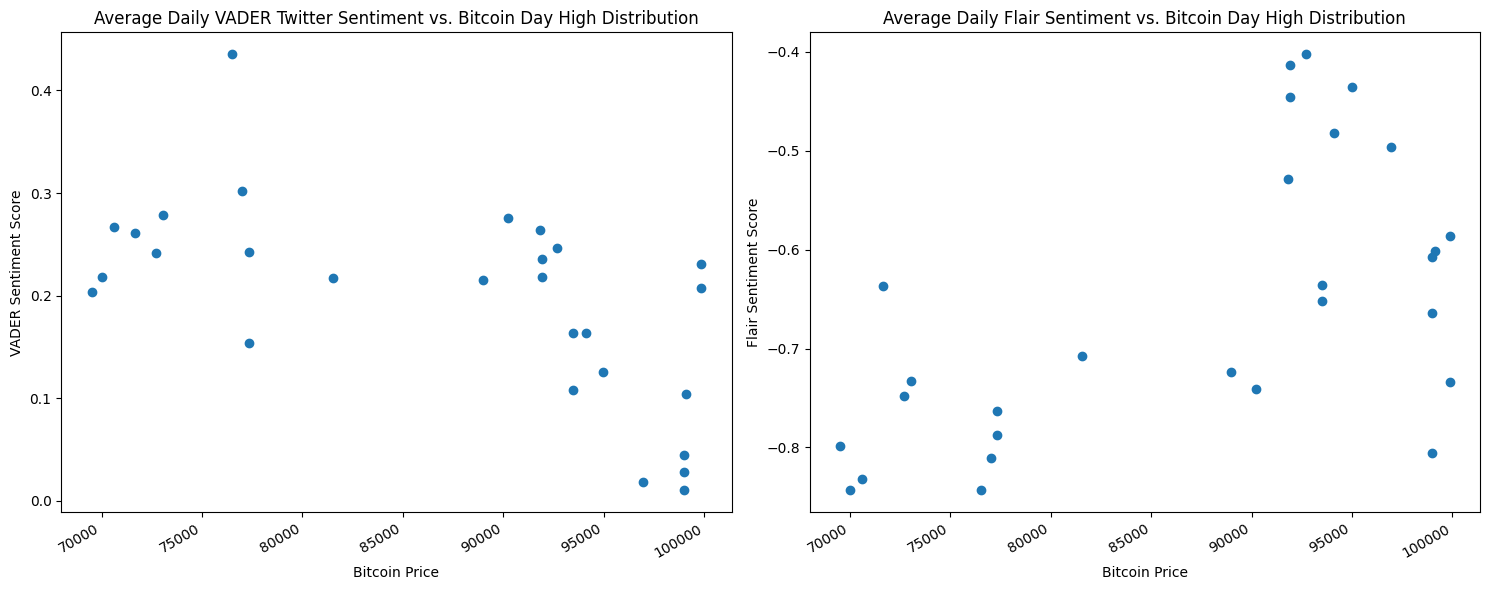

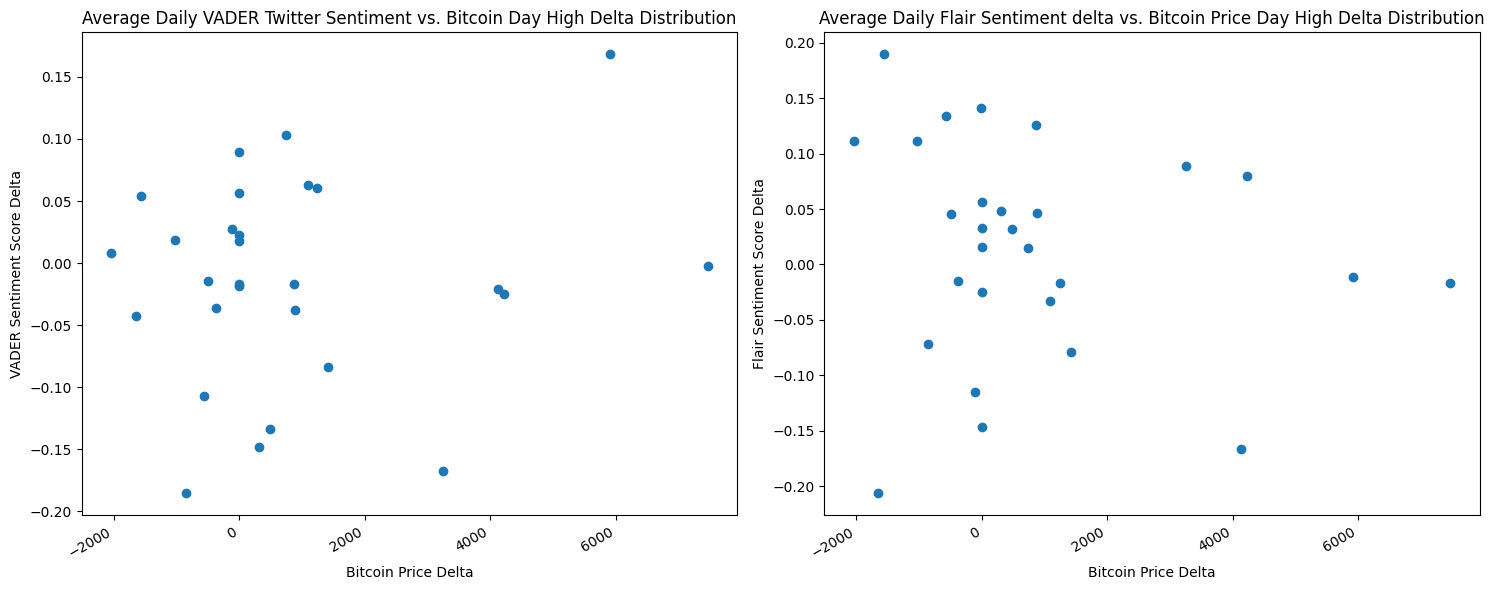

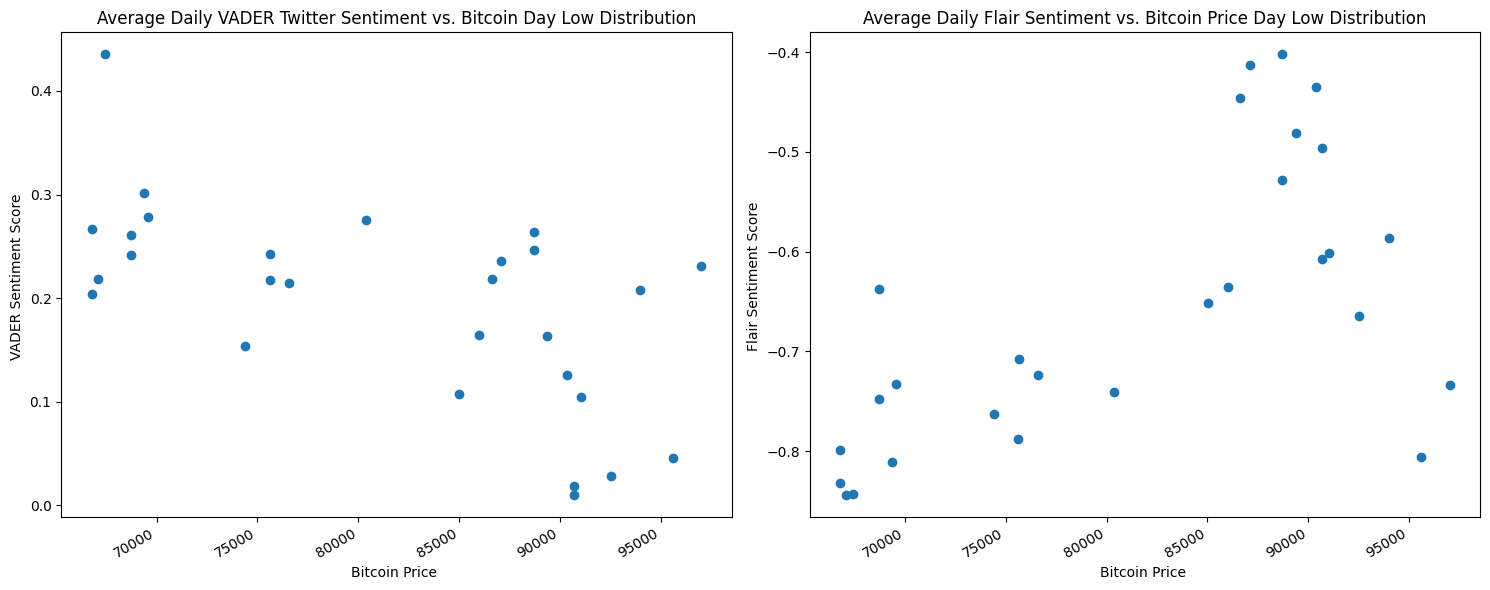

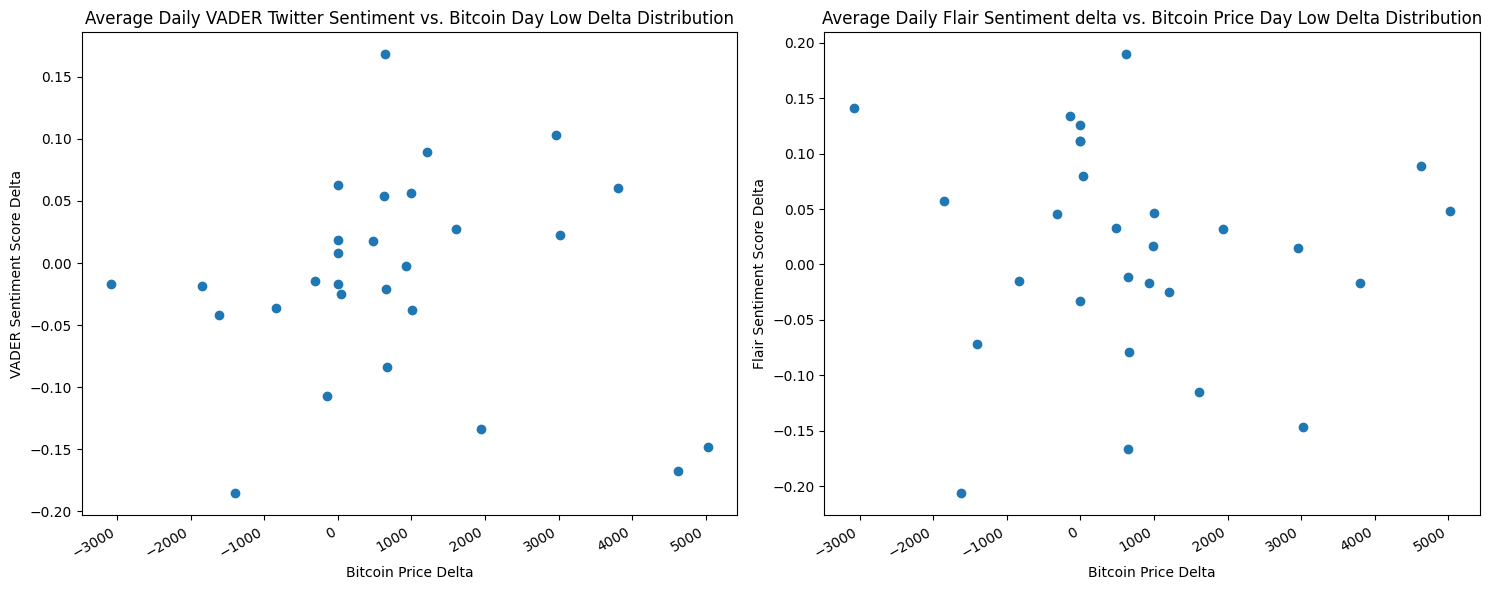

In [8]:
# Draw scatter plot to visualize correlation between mean daily day high vs. mean daily Twitter sentiment
p.sentiment_price_scatter(day_btc_tw['dayHigh'], day_btc_tw['vd_compound_mean'], day_btc_tw['fl_confidence_mean'], 
  "Average Daily VADER Twitter Sentiment vs. Bitcoin Day High Distribution","Bitcoin Price","VADER Sentiment Score",
  "Average Daily Flair Sentiment vs. Bitcoin Day High Distribution", "Bitcoin Price", "Flair Sentiment Score")

# Draw scatter plot to visualize correlation between mean daily day high delta vs. mean daily Twitter sentiment delta
p.sentiment_price_scatter(day_btc_tw['dayHigh_delta'], day_btc_tw['vd_compound_mean_delta'], day_btc_tw['fl_confidence_mean_delta'], 
  "Average Daily VADER Twitter Sentiment vs. Bitcoin Day High Delta Distribution","Bitcoin Price Delta","VADER Sentiment Score Delta",
  "Average Daily Flair Sentiment delta vs. Bitcoin Price Day High Delta Distribution", "Bitcoin Price Delta", "Flair Sentiment Score Delta")

# Draw scatter plot to visualize correlation between mean daily day low vs. mean daily Twitter sentiment 
p.sentiment_price_scatter(day_btc_tw['dayLow'], day_btc_tw['vd_compound_mean'], day_btc_tw['fl_confidence_mean'], 
  "Average Daily VADER Twitter Sentiment vs. Bitcoin Day Low Distribution","Bitcoin Price ","VADER Sentiment Score ",
  "Average Daily Flair Sentiment vs. Bitcoin Price Day Low Distribution", "Bitcoin Price ", "Flair Sentiment Score ")

# Draw scatter plot to visualize correlation between mean daily day low delta vs. mean daily Twitter sentiment delta
p.sentiment_price_scatter(day_btc_tw['dayLow_delta'], day_btc_tw['vd_compound_mean_delta'], day_btc_tw['fl_confidence_mean_delta'], 
  "Average Daily VADER Twitter Sentiment vs. Bitcoin Day Low Delta Distribution","Bitcoin Price Delta","VADER Sentiment Score Delta",
  "Average Daily Flair Sentiment delta vs. Bitcoin Price Day Low Delta Distribution", "Bitcoin Price Delta", "Flair Sentiment Score Delta")

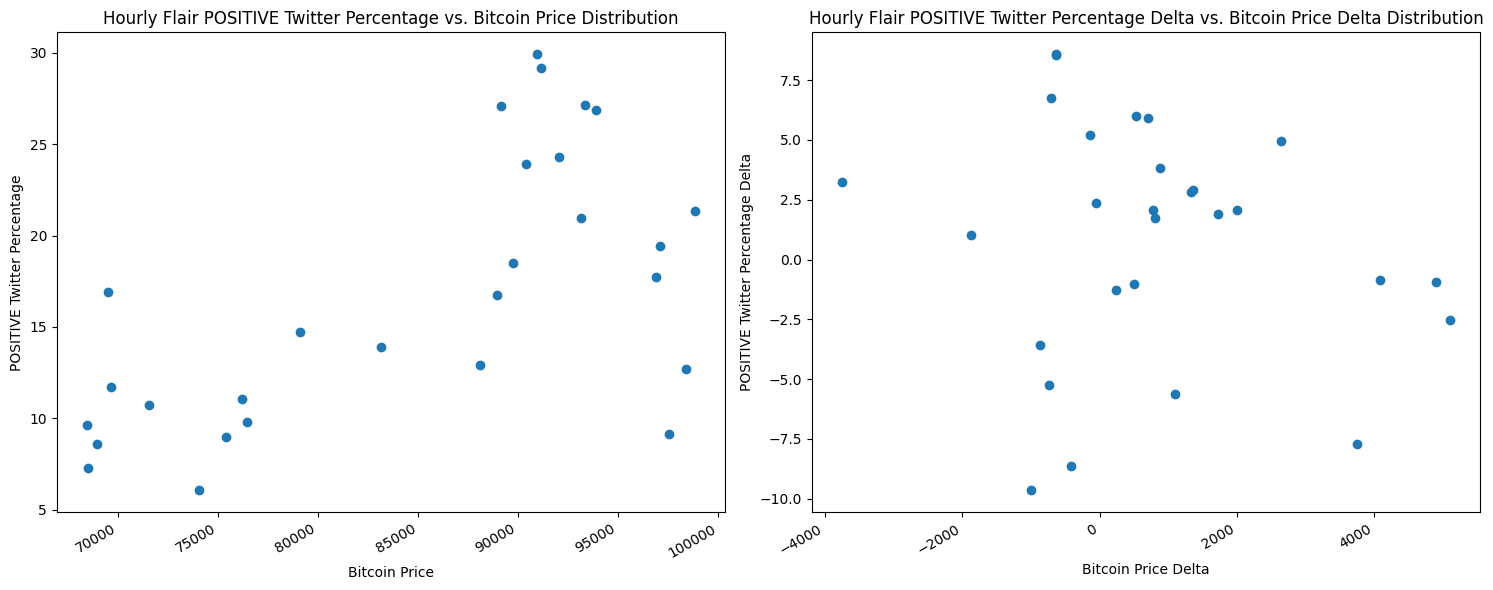

In [9]:
# Draw scatter plot to visualize correlation between daily price vs. POSITIVE twitter percentage
p.sentiment_price_delta_scatter(day_btc_tw['price'], day_btc_tw['price_delta'], day_btc_tw['POSITIVE'], day_btc_tw['POSITIVE_delta'], 
  "Hourly Flair POSITIVE Twitter Percentage vs. Bitcoin Price Distribution","Bitcoin Price","POSITIVE Twitter Percentage",
  "Hourly Flair POSITIVE Twitter Percentage Delta vs. Bitcoin Price Delta Distribution", "Bitcoin Price Delta", "POSITIVE Twitter Percentage Delta")

## III Random Forest Prediction with daily data

In [1]:
# Import external libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [4]:
# Load and preprocess data
df = pd.read_csv('day_btc_tw.csv')
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)

df.head(3)

,open,close,price,volume,dayHigh,dayLow,SMA_5,SMA_10,RSI,MACD,...,vd_compound_med,fl_confidence_med,NEGATIVE,POSITIVE,price_delta,fl_confidence_mean_delta,vd_compound_mean_delta,fl_confidence_med_delta,vd_compound_med_delta,POSITIVE_delta
time,,,,,,,,,,,,,,,,,,,,,
2024-10-30,72508.29,72515.00,72240.830417,1.336778e+12,73624.98,69705.76,72238.347000,72298.577625,48.791275,137.377439,...,0.4738,-0.999265,96.039604,3.960396,703.530000,-0.061290,-0.021317,0.000072,0.1126,-4.332287
2024-10-31,72364.69,70327.64,71540.485417,1.027684e+12,73060.00,69559.33,71730.912583,71912.237500,39.340133,-538.661435,...,0.0000,-0.999045,89.285714,10.714286,-700.345000,0.134057,-0.106898,0.000220,-0.4738,6.753890
2024-11-01,70279.98,69493.18,69668.325833,1.174492e+12,72684.02,68720.00,69737.412583,69838.189583,41.376214,-312.413866,...,0.4738,-0.999647,88.262911,11.737089,-1872.159583,-0.015070,-0.036300,-0.000602,0.4738,1.022803


In [5]:
# Feature sets
technical_features = ['SMA_5', 'SMA_10', 'RSI', 'MACD']
sentiment_features = ['vd_compound_mean','fl_confidence_mean', 'vd_compound_med', 'fl_confidence_med', 'POSITIVE']
price_features = ['price','volume', 'dayHigh', 'dayLow']

# Add volatility as a feature
df['volatility'] = df['price'].pct_change().rolling(window=10).std() * 100  # Rolling std dev of price changes

# Combine features and target
X = df[technical_features + sentiment_features + price_features + ['volatility']].copy()
y = df['price'].shift(-1)  # Predict next day's price

In [6]:
# Remove NaN values from both X and y
df_clean = pd.concat([X, y.rename('target_price')], axis=1).dropna()

# Ensure 'price' is a single Series
if isinstance(df_clean['price'], pd.DataFrame):
    df_clean['price'] = df_clean['price'].iloc[:, 0]  # Select the first column

df_clean.head(3)

,SMA_5,SMA_10,RSI,MACD,vd_compound_mean,fl_confidence_mean,vd_compound_med,fl_confidence_med,POSITIVE,price,volume,dayHigh,dayLow,volatility,target_price
time,,,,,,,,,,,,,,,
2024-11-09,76457.327167,76486.552042,47.888550,36.774848,0.243044,-0.787550,0.0,-0.991986,9.771987,76446.790417,1.164213e+12,77312.18,75608.00,2.708232,79090.067917
2024-11-10,78805.268333,78421.026500,76.619380,717.021027,0.217728,-0.707392,0.0,-0.998484,14.726027,79090.067917,1.135664e+12,81534.28,75648.00,2.784052,83174.197500
2024-11-11,82501.198417,81878.668292,73.324057,2009.252278,0.214978,-0.724022,0.0,-0.996419,13.879004,83174.197500,2.137493e+12,89000.00,76580.66,2.734630,88076.196667


In [7]:
# Split data for machine learning
X = df_clean[technical_features + sentiment_features + price_features + ['volatility']]
y = df_clean['target_price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [8]:
# Train Random Forest Model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

RandomForestRegressor(random_state=42)

In [9]:
# Predict and evaluate
y_pred = model.predict(X_test_scaled)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\n2. Model Performance:")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R² Score: {r2:.4f}")


2. Model Performance:
RMSE: 6177.44
MAE: 4856.35
R² Score: -0.7132


## IV Feature Importance in Relation with Bitcoin Prices

In [10]:
# Feature Importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values(by='importance', ascending=False)

feature_importance.head(3)

,feature,importance
9,price,0.252978
11,dayHigh,0.187530
0,SMA_5,0.139382


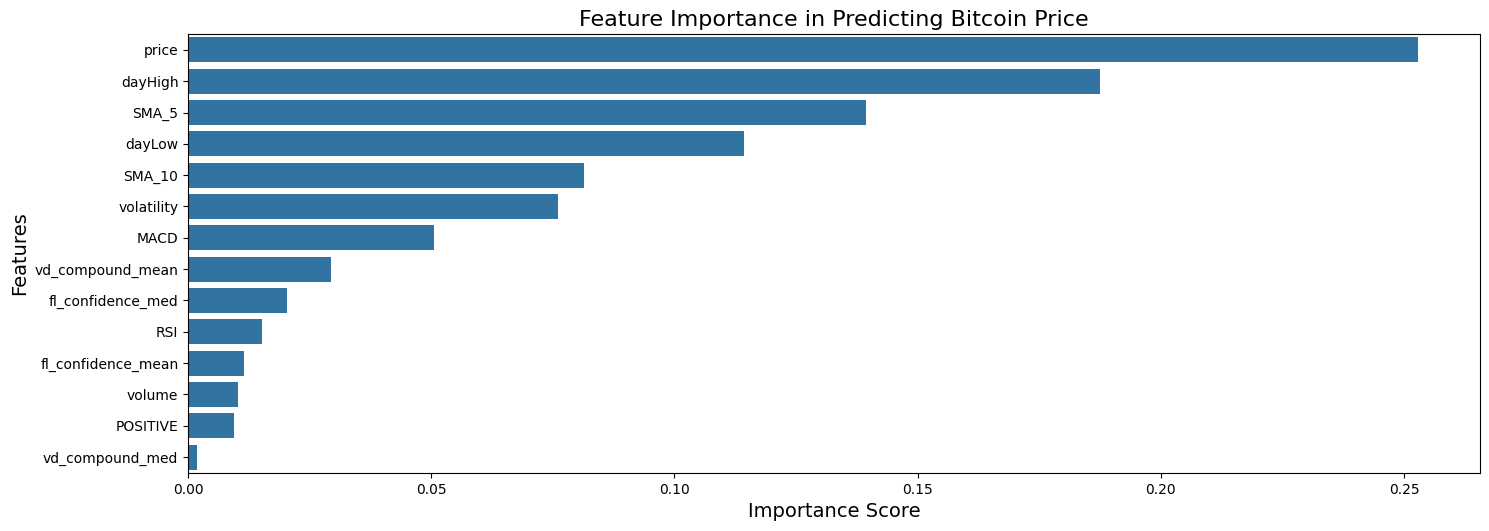

In [11]:
# Plotting
plt.figure(figsize=(15, 25))

# 1. Feature Importance Plot
plt.subplot(5, 1, 1)
sns.barplot(data=feature_importance, x='importance', y='feature')
plt.title('Feature Importance in Predicting Bitcoin Price', fontsize=16)
plt.xlabel('Importance Score', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.tight_layout()
plt.show()

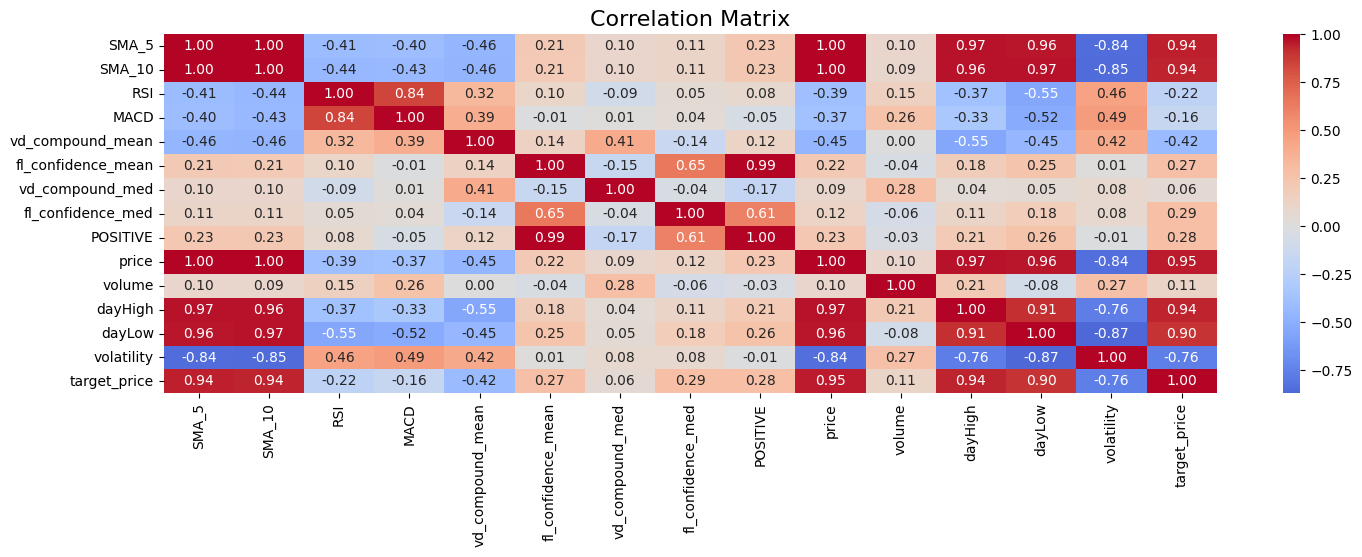

In [12]:
# 2. Correlation Matrix Heatmap
plt.figure(figsize=(15, 25))

correlation_matrix = df_clean.corr()
plt.subplot(5, 1, 2)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt=".2f")
plt.title('Correlation Matrix', fontsize=16)
plt.tight_layout()
plt.show()

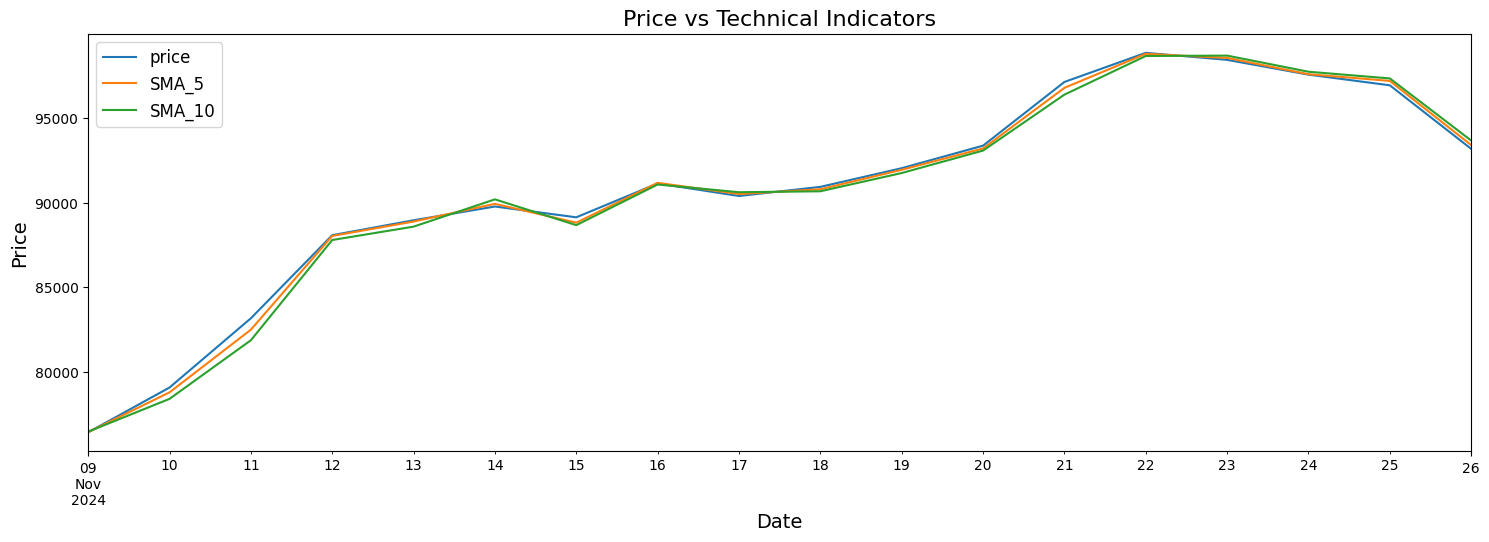

In [13]:
# 3. Price vs Technical Indicators
plt.figure(figsize=(15, 25))

plt.subplot(5, 1, 3)
df_clean[['price', 'SMA_5', 'SMA_10']].plot(ax=plt.gca())
plt.title('Price vs Technical Indicators', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.legend(loc='upper left', fontsize=12)
plt.tight_layout()

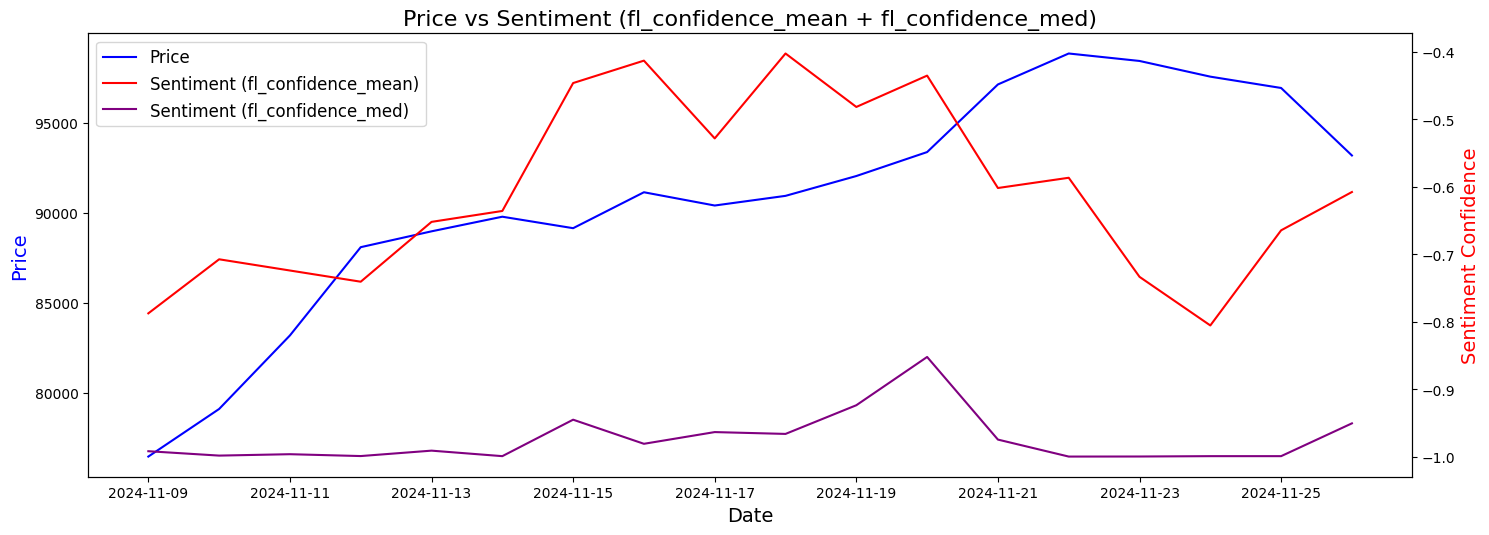

In [24]:
# 4. Sentiment (fl_confidence) vs Price
plt.figure(figsize=(15, 25))

plt.subplot(5, 1, 4)
ax1 = plt.gca()
ax2 = ax1.twinx()
ax1.plot(df_clean.index, df_clean['price'], color='blue', label='Price')
ax2.plot(df_clean.index, df_clean['fl_confidence_mean'], color='red', label='Sentiment (fl_confidence_mean)')
ax2.plot(df_clean.index, df_clean['fl_confidence_med'], color='purple', label='Sentiment (fl_confidence_med)')
plt.title('Price vs Sentiment (fl_confidence_mean + fl_confidence_med)', fontsize=16)
ax1.set_xlabel('Date', fontsize=14)
ax1.set_ylabel('Price', fontsize=14, color='blue')
ax2.set_ylabel('Sentiment Confidence', fontsize=14, color='red')
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=12)
plt.tight_layout()

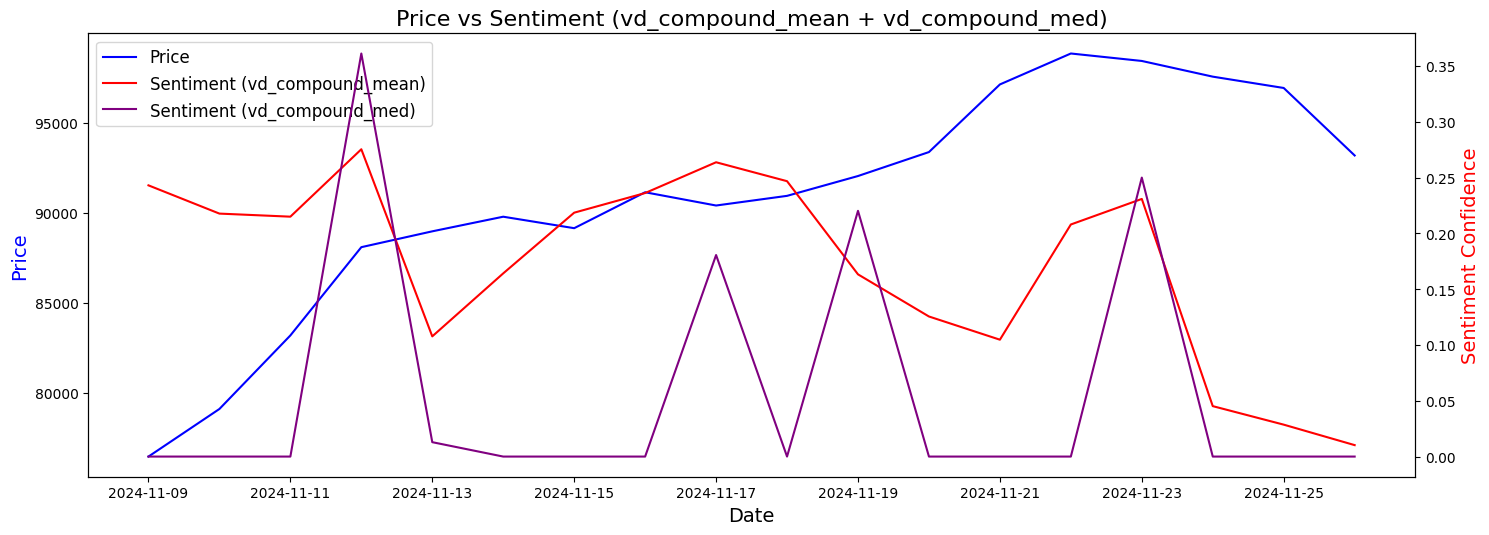

In [25]:
# 5. Sentiment (vd_compound) vs Price
plt.figure(figsize=(15, 25))

plt.subplot(5, 1, 4)
ax1 = plt.gca()
ax2 = ax1.twinx()
ax1.plot(df_clean.index, df_clean['price'], color='blue', label='Price')
ax2.plot(df_clean.index, df_clean['vd_compound_mean'], color='red', label='Sentiment (vd_compound_mean)')
ax2.plot(df_clean.index, df_clean['vd_compound_med'], color='purple', label='Sentiment (vd_compound_med)')
plt.title('Price vs Sentiment (vd_compound_mean + vd_compound_med)', fontsize=16)
ax1.set_xlabel('Date', fontsize=14)
ax1.set_ylabel('Price', fontsize=14, color='blue')
ax2.set_ylabel('Sentiment Confidence', fontsize=14, color='red')
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=12)
plt.tight_layout()

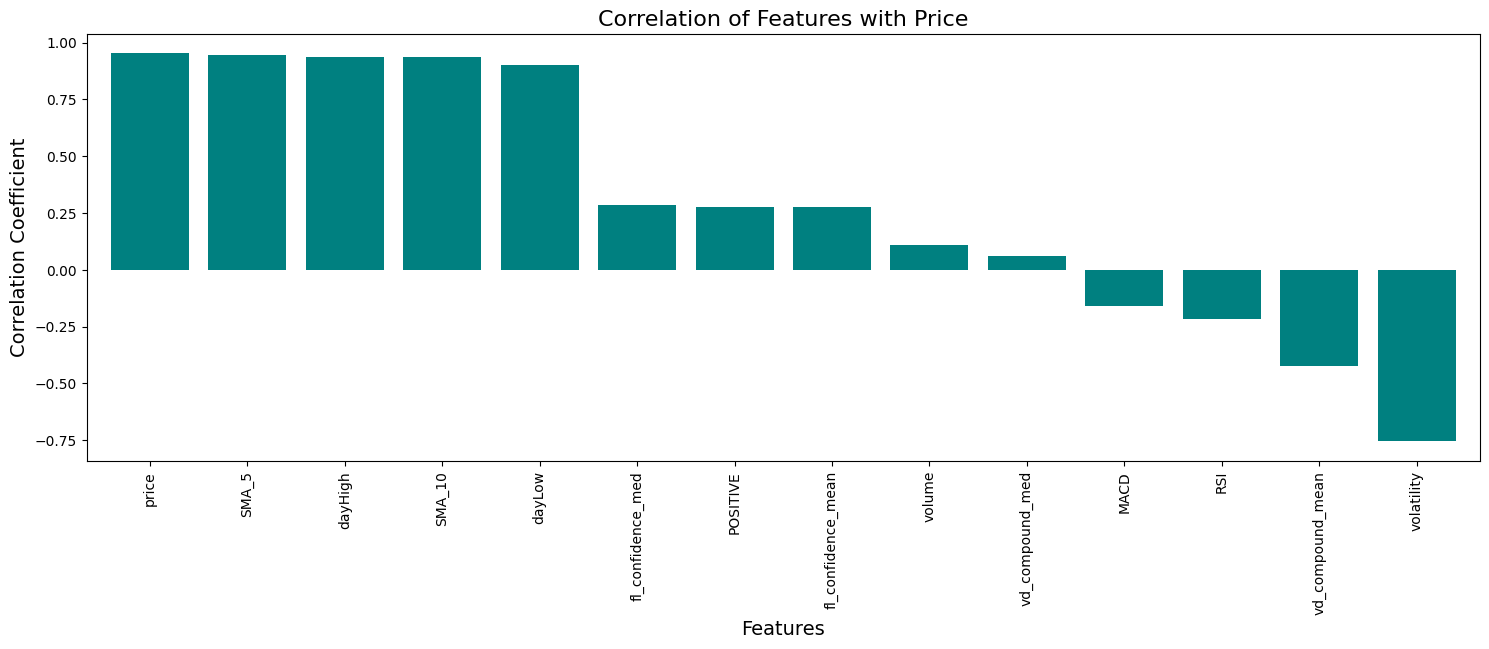

In [14]:
# 6. Correlation of Features with Price
plt.figure(figsize=(15, 25))

plt.subplot(5, 1, 5)
price_correlations = correlation_matrix['target_price'].sort_values(ascending=False)
price_correlations.drop('target_price').plot(kind='bar', color='teal', width=0.8)
plt.title('Correlation of Features with Price', fontsize=16)
plt.xlabel('Features', fontsize=14)
plt.ylabel('Correlation Coefficient', fontsize=14)
plt.tight_layout()

plt.show()

In [28]:
# Print Results
print("\n1. Feature Group Importance:")
tech_importance = feature_importance[feature_importance['feature'].isin(technical_features)]['importance'].sum()
sentiment_importance = feature_importance[feature_importance['feature'].isin(sentiment_features)]['importance'].sum()
price_importance = feature_importance[feature_importance['feature'].isin(price_features + ['volatility'])]['importance'].sum()
print(f"Technical Indicators: {tech_importance:.4f}")
print(f"Sentiment Features: {sentiment_importance:.4f}")
print(f"Price Features: {price_importance:.4f}")

print("\n2. Correlation with Price:")
print(price_correlations)



1. Feature Group Importance:
Technical Indicators: 0.2865
Sentiment Features: 0.0724
Price Features: 0.6411

2. Correlation with Price:
target_price          1.000000
price                 0.952400
SMA_5                 0.943835
dayHigh               0.938059
SMA_10                0.935798
dayLow                0.899745
fl_confidence_med     0.286518
POSITIVE              0.277929
fl_confidence_mean    0.274970
volume                0.109995
vd_compound_med       0.059827
MACD                 -0.158789
RSI                  -0.217598
vd_compound_mean     -0.422183
volatility           -0.755405
Name: target_price, dtype: float64


## V Retrain Random Forest Prediction Using Feature Importance

In [22]:
# Load and preprocess data
df = pd.read_csv('day_btc_tw.csv')
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)

df.head(3)

,open,close,price,volume,dayHigh,dayLow,SMA_5,SMA_10,RSI,MACD,...,vd_compound_med,fl_confidence_med,NEGATIVE,POSITIVE,price_delta,fl_confidence_mean_delta,vd_compound_mean_delta,fl_confidence_med_delta,vd_compound_med_delta,POSITIVE_delta
time,,,,,,,,,,,,,,,,,,,,,
2024-10-30,72508.29,72515.00,72240.830417,1.336778e+12,73624.98,69705.76,72238.347000,72298.577625,48.791275,137.377439,...,0.4738,-0.999265,96.039604,3.960396,703.530000,-0.061290,-0.021317,0.000072,0.1126,-4.332287
2024-10-31,72364.69,70327.64,71540.485417,1.027684e+12,73060.00,69559.33,71730.912583,71912.237500,39.340133,-538.661435,...,0.0000,-0.999045,89.285714,10.714286,-700.345000,0.134057,-0.106898,0.000220,-0.4738,6.753890
2024-11-01,70279.98,69493.18,69668.325833,1.174492e+12,72684.02,68720.00,69737.412583,69838.189583,41.376214,-312.413866,...,0.4738,-0.999647,88.262911,11.737089,-1872.159583,-0.015070,-0.036300,-0.000602,0.4738,1.022803


In [23]:
# Feature sets
technical_features = ['SMA_5', 'SMA_10']
sentiment_features = ['fl_confidence_mean', 'fl_confidence_med', 'POSITIVE']
price_features = ['price','volume', 'dayHigh', 'dayLow']

X = df[technical_features + sentiment_features + price_features].copy()
y = df['price'].shift(-1)  # Predict next day's price

In [24]:
# Remove NaN values from both X and y
df_clean = pd.concat([X, y.rename('target_price')], axis=1).dropna()

# Ensure 'price' is a single Series
if isinstance(df_clean['price'], pd.DataFrame):
    df_clean['price'] = df_clean['price'].iloc[:, 0]  # Select the first column

df_clean.head(3)

,SMA_5,SMA_10,fl_confidence_mean,fl_confidence_med,POSITIVE,price,volume,dayHigh,dayLow,target_price
time,,,,,,,,,,
2024-10-30,72238.347000,72298.577625,-0.867068,-0.999265,3.960396,72240.830417,1.336778e+12,73624.98,69705.76,71540.485417
2024-10-31,71730.912583,71912.237500,-0.733011,-0.999045,10.714286,71540.485417,1.027684e+12,73060.00,69559.33,69668.325833
2024-11-01,69737.412583,69838.189583,-0.748081,-0.999647,11.737089,69668.325833,1.174492e+12,72684.02,68720.00,69523.744167


In [25]:
# Split data for machine learning
X = df_clean[technical_features + sentiment_features + price_features ]
y = df_clean['target_price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [26]:
# Train Random Forest Model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

RandomForestRegressor(random_state=42)

In [27]:
# Predict and evaluate
y_pred = model.predict(X_test_scaled)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nUpdated Model Performance:")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R² Score: {r2:.4f}")


Updated Model Performance:
RMSE: 2746.96
MAE: 2229.71
R² Score: 0.9279
